# Session Analysis

In [115]:


from Lab28_session_header import *

from uncertainties import ufloat
import uncertainties as unc
from session_data_handling import get_data_from_session, search_runs_in_db


from get_data_from_hdf5 import get_data


# Please update these path varibles to your local machine.
env_session_file_location = r"\\172.24.54.234\\NAS-Lab28\\Data"
NAS_Path = r"\\172.24.54.234\\NAS-Lab28"
Plot_path= r"\\172.24.54.234\\NAS-Lab28\\Users\\Bane\\Plots"

#Bg database
bgdb=pd.read_csv(NAS_Path+"\\DataBases\\bg_db.csv")
#make blank dataframe for background subtraction debugging

blankBG_DF= pd.DataFrame({"anode":[0]*50000,"cathode":[0]*50000,"time":[0]*50000})






## Build Run list from new database

In [116]:
Connection = sqlite3.connect(NAS_Path+"\\Data\\lab_28_run.db")
RunDatabase = pd.read_sql("SELECT * from runs", Connection).sort_values(by='run', ascending=False)
Connection.close()


In [117]:
RunDatabase

,run,old_run_name,session,date,configuration,grid,run_type,cathode_V,cathode_V_err,cathode_grid_V,...,drift_length_mm_err,run_notes,extraction_length_mm,extraction_length_mm_err,collection_length_mm,collection_length_mm_err,cathode_preamp_gain,cathode_preamp_gain_err,anode_preamp_gain,anode_preamp_gain_err
1205,1206,20250624-01206,49,250624,352,2.0,test,0.0,0.5,0.0,...,0.07,baseline outside uv,1.57,0.01,1.57,0.010,0.770,0.060,0.657,0.060
1204,1205,20250624-01205,49,250624,352,2.0,test,0.0,0.5,0.0,...,0.07,baseline outside uv,1.57,0.01,1.57,0.010,0.770,0.060,0.657,0.060
1203,1204,20250624-01204,49,250624,352,2.0,test,0.0,0.5,0.0,...,0.07,baseline outside uv,1.57,0.01,1.57,0.010,0.770,0.060,0.657,0.060
1202,1203,20250624-01203,49,250624,352,2.0,test,0.0,0.5,0.0,...,0.07,baseline outside uv,1.57,0.01,1.57,0.010,0.770,0.060,0.657,0.060
1201,1202,20250624-01202,49,250624,352,2.0,test,0.0,0.5,0.0,...,0.07,baseline outside uv,1.57,0.01,1.57,0.010,0.770,0.060,0.657,0.060
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4,5,20240517-13100037,1,240517,None,NaN,None,NaN,NaN,NaN,...,0.08,None,0.00,0.00,0.51,0.006,0.656,0.001,0.708,0.001
3,4,20240517-13100036,1,240517,None,NaN,None,NaN,NaN,NaN,...,0.08,None,0.00,0.00,0.51,0.006,0.656,0.001,0.708,0.001
2,3,20240517-13100035,1,240517,None,NaN,None,NaN,NaN,NaN,...,0.08,None,0.00,0.00,0.51,0.006,0.656,0.001,0.708,0.001
1,2,20240517-13100034,1,240517,None,NaN,None,NaN,NaN,NaN,...,0.08,None,0.00,0.00,0.51,0.006,0.656,0.001,0.708,0.001


In [118]:
def Get_SessionFile(run_number: int) ->dict:
    """
    Get_SessionFile(run_number: int) -> dict
    This function takes a run number and returns a dictionary of the session file."""
    RunInfo = RunDatabase.query(f'run == {run_number}').iloc[0]
    session_file_name= f"{env_session_file_location}\\\{RunInfo['session']:03}_{RunInfo['date']}.h5"
    session_dict = get_data(session_file_name, run_number)
    return session_dict

def Get_Waveform_from_session(run_number: int):
    """
    Get_Waveform_from_session(run_number: int) -> dict
    This function takes a run number and returns a dictionary of the waveforms from the session file."""
    RunInfo = RunDatabase.query(f'run == {run_number}').iloc[0]
    session_file_name= f"{env_session_file_location}\\\{RunInfo['session']:03}_{RunInfo['date']}.h5"
    run_dict={}
    with h5py.File(session_file_name, 'r') as session_h5:
        keys = list(session_h5["run"][str(run_number)].keys())
        for  key in keys:
            run_dict[key] = session_h5['run'][str(run_number)][key][:]
    return run_dict    

def GetBGRun(run):
    global bgdb
    try:
        return bgdb.query("run==%i"%(run)).iloc[0]["background"]
    except:
        return -1

def get_session_filename(run_number: int) -> str:
    """
    get_session_filename(run_number: int) -> str
    This function takes a run number and returns the session file name."""
    RunInfo = RunDatabase.query(f'run == {run_number}').iloc[0]
    session_file_name= f"{env_session_file_location}\\\{RunInfo['session']:03}_{RunInfo['date']}.h5"
    return session_file_name

In [119]:
def GetSinBG(x_data,y_data,time_start=0,time_stop=10,stepsize=100,debug=10,plot=True):
    
    x_fit=[]
    y_fit=[]
    
    if np.mean(y_data)*1000 <= 0.001:
        print("issue with weird data")
        return [0,0,0,0,0],[0,0,0,0,0]

    if len(x_data) <=1 or len(y_data)<=1 or len(x_data) != len(y_data):

        print("X and Y need to be equal in length and need two more data points")
        print(" X: ", len(x_data), " Y :" ,len(y_data))
        return np.zeros(len(x_data)),np.zeros(len(y_data))
    
    if plot: sin_figure, sin_ax =plt.subplots(figsize=(9,4))


    # Determine fitting limits
    time_resolution= x_data[1] - x_data[0]
    index_start = int(time_start/time_resolution)
    index_stop = int(time_stop/time_resolution)
    if debug>=10: print("Start ",time_start,index_start," stop ",time_stop,index_stop)
    
    if plot:
        sin_ax.errorbar(x_data,y_data,alpha=0.75,
    linestyle=(0, (5, 1)),c="gray",label="Data")
        sin_ax.legend()

    # smooth out the data
    smooth_slice=slice(int(stepsize/2),-(int(stepsize/2)+1))
    smooth_ydata=np.convolve(y_data,
     np.ones(stepsize)/stepsize,mode="same")[smooth_slice]
    smooth_xdata=x_data[smooth_slice]
    if plot:sin_ax.errorbar(smooth_xdata,smooth_ydata,
    linestyle=(0, (5, 1)),label="Smooth Data")

    # Prepare for fit
    x_fitdata=smooth_xdata[index_start:index_stop-int(stepsize/2)]
    y_fitdata=smooth_ydata[index_start:index_stop-int(stepsize/2)]
    #if plot:sin_ax.errorbar(x_fitdata,y_fitdata,fmt=":",label="Fit Data")

    ## fit the expontial tail first 
    if y_fitdata[0] < y_fitdata[-1]:
        print("Weird structure skipping sin fit")
        return [0,0,0,0,0],[0,0,0,0,0]

    p0_tail_only = [np.max(y_fitdata),-0.001]
    bounds_tail_only = [np.max(y_fitdata)*.75,-0.01],[np.max(y_fitdata)*1.25,0.0001]
    if debug >=10:
        print("Tail Only")
        print("P0", p0_tail_only)
        print("bounds",bounds_tail_only)

    params_tail_only, covariance_tail_only = curve_fit(simple_exp, 
        x_fitdata, y_fitdata,p0=p0_tail_only,bounds=bounds_tail_only)


    x_fit=smooth_xdata
    y_fit_tail_only=simple_exp(x_fit,*params_tail_only)
    if plot:
        sin_ax.errorbar(x_fit,y_fit_tail_only,
        linestyle=":",label="Only tail")
        

    if debug>=5: print("Only exp tail paramaters", params_tail_only)

    # subtracted the tail

    tail_sub_fitdata = y_fitdata - simple_exp(x_fitdata,*params_tail_only)

    
    #po = amp,freq, phase, exp amp, decay
    #p0=[max(y_fitdata)/2-min(y_fitdata)/2,0.25,0.5,params_tail_only[0],params_tail_only[1]]
    #bounds=[0,0.0001,-np.pi,params_tail_only[0]*0.8,params_tail_only[1]*1.2],[p0[0],1.0,np.pi,params_tail_only[0]*1.2,params_tail_only[1]*0.8]

    # po for freq. try to count number of local max for time range

    # amp, freq, phase,
    p0 = [(np.max(tail_sub_fitdata) - np.min(tail_sub_fitdata))/2, 0.14,0 ]
    bounds =[0,0,-3.14 ],[((np.max(tail_sub_fitdata) - np.min(tail_sub_fitdata))/2 )*1.3,
            1,3.14]


    if debug>=5:
        print("Fit P0",p0)
        print("Bounds",bounds)
    params, covariance = [0,0,0],[[0,0,0],[0,0,0],[0,0,0]]
    try: 
        params, covariance = curve_fit(sin, 
            x_fitdata, tail_sub_fitdata,p0=p0,bounds=bounds)
    except:
        print("Issue with sin fit")

    if debug >=5:
        print("Parameters", np.round(params,3))
    if debug>=10: print("Covariance",covariance)
    
    x_fit=smooth_xdata
    y_fit=sin(x_fit,params[0],params[1],params[2])
    if plot:
        sin_ax.errorbar(x_fitdata,sin_exp(x_fitdata,params[0],params[1],params[2],
            params_tail_only[0], params_tail_only[1]),
        linestyle="--",label="Fit Results")
        sin_ax.errorbar(x_fit,y_fit+params_tail_only[0],linestyle="--",label="Sin Fit")
        sin_ax.errorbar(x_fit[::stepsize],(smooth_ydata-y_fit)[::stepsize],
                        color="black",fmt="-.",linewidth=0.75,label="Subtracted")

    y_fit_Stddev=sin_exp(x_fitdata,params[0],params[1],params[2],
            params_tail_only[0], params_tail_only[1])
    dev = np.sqrt(np.sum(abs(y_fit_Stddev-y_fitdata)**2)/len(y_fit))
    if debug >=5: print("Fit deviation from fitting data", dev)
    if dev>1:
        print("\t\t!!!!!!WARNING!!!!!!!!!  Issue with sin fit Large Deviation")
    #print((y_fit_Stddev-y_fitdata)/y_fitdata )
    if plot:
        sin_ax.grid()
        sin_ax.legend()
        #plt.xlim(time_start-12,time_stop-8)
        #plt.ylim(params[4] + params[3]*time_stop,params[4]*1.1)

    return [params[0],params[1],params[2],
            params_tail_only[0], params_tail_only[1]],[covariance[0][0],covariance[1][1],covariance[2][2],covariance_tail_only[0][0],covariance_tail_only[1][1]]

In [120]:
filename = r"\\172.24.54.234\\NAS-Lab28\\Data\\035_250311.h5"

dat=get_data(filename)


In [121]:
def Run_oldtonew(run):
    """
    Run_oldtonew(run) -> int
    This function takes a run number and returns the new run number."""
    global RunDatabase
    try:
        return RunDatabase[RunDatabase['old_run_name'].str.contains(f'{run:05}')].iloc[0]['run']
    except:
        print("No old run number found")
        return -1
    

def Run_newtoold(run):
    """
    Run_newtoold(run) -> int
    This function takes a run number and returns the old run number."""
    global RunDatabase
    try:
        old_run_name=RunDatabase[RunDatabase['run'] == run].iloc[0]['old_run_name']
    except:
        print("No new run number found")
        return -1
    
    
    split =old_run_name.split("-")
    if len(split[1]) > 5:
        split[1]= split[1][3:]
        split[1] = str(int(split[1]))
        


    return int(split[1])

In [122]:
Run_newtoold(1000)

804

In [123]:
stepcounts=[100]
stepcount=200
diffsizes=[200]
debug=4
plot=True
savefig=True

good_runs=[378,391,800,993]
run_number=good_runs[1]




waveform = Get_Waveform_from_session(run_number)

old_rn = Run_newtoold(run_number)
bgnum = Run_oldtonew(GetBGRun(old_rn))
background_waveform = Get_Waveform_from_session(bgnum)



def Analyze_Anode(waveform,background_waveform, stepcounts=[100], diffsizes=[100],debug=0,plot=False,savefig=True):

    for stepcount in stepcounts:
        for diffsize in diffsizes:
            if debug>=1:
                print("::Anode Analysis::")
                print("Run Number",run_number)
                print("Background Run Number",bgnum)

            AnalysisResults={}

            last_index= np.min([len(waveform["time"]),len(waveform["anode"]),len(background_waveform["anode"]),len(background_waveform["time"])])
            
            waveform["time"] = waveform["time"][:last_index]
            waveform["anode"] = waveform["anode"][:last_index]
            background_waveform["time"] = background_waveform["time"][:last_index]
            background_waveform["anode"] = background_waveform["anode"][:last_index]
            
            waveform["time"] = waveform["time"]/1e3 #convert to us
            background_waveform["anode"] = background_waveform["anode"]*1e3 #convert to mv
            waveform["anode"] = waveform["anode"]*1e3 #convert to mv

            time_resolution = waveform["time"][1] - waveform["time"][0]
            #Find the average anode for the first 5 us and subtract to normalize. 
            anode_normalize = waveform["anode"][:int(5/time_resolution)].mean()

            waveform["norm"] = {}
            waveform["denoised"] = {}
            waveform["subtracted"] = {}
            waveform["analyzed"]={}
            
            #Find the average anode for the first 5 us and subtract to normalize.   
            waveform["norm"]["anode"] = waveform["anode"] - anode_normalize
            waveform["norm"]["anode-bg"] = background_waveform["anode"] - background_waveform["anode"][:int(5/time_resolution)].mean()
            
            edge_slice=slice(0,int(45/time_resolution))

            if plot==1:
                fig_anode, ax_anode = plt.subplots(figsize=(9,5))
                ax_anode.grid()
                ax_anode.set_xlabel("time [us]")
                ax_anode.set_ylabel("Signal [mV]")
                ax_anode.errorbar(x=waveform["time"][edge_slice],y=waveform["norm"]["anode"][edge_slice], label="Normalized Signal")
                ax_anode.errorbar(x=waveform["time"][edge_slice],y=waveform["norm"]["anode-bg"][edge_slice], label="Back Ground")


            #Find and remove noise
            denoise_plot = plot==1 or plot==True

            Anode_noise_params, Anode_noise_cov =GetSinBG(waveform["time"],waveform["norm"]["anode"],27.5,50,debug=debug,plot=denoise_plot)
            BG_noise_params, BG_noise_cov = GetSinBG(waveform["time"],waveform["norm"]["anode-bg"],25.5,50,150,debug=debug,plot=denoise_plot)
                                                    
            noise_waveform = sin(waveform["time"],Anode_noise_params[0],Anode_noise_params[1],Anode_noise_params[2])
            bg_noise_waveform = sin(waveform["time"],BG_noise_params[0],BG_noise_params[1],BG_noise_params[2])
            

            #subtract the noise from the anode signal
            waveform["denoised"]["anode"] = waveform["norm"]["anode"] - noise_waveform
            waveform["denoised"]["anode-noise"]= noise_waveform
            waveform["denoised"]["anode-bg"] = waveform["norm"]["anode-bg"] - bg_noise_waveform   
            waveform["denoised"]["anode-bg-noise"]= bg_noise_waveform  

            #Dr the background signal (anode off)
            # Need to to fit the decay rate of the background signal to extrapolate the background signal
            if plot==1:
                fig_anode_bg, ax_anode_bg = plt.subplots(figsize=(9,5))
                ax_anode_bg.grid()
                ax_anode_bg.set_xlabel("time [us]")
                ax_anode_bg.errorbar(x=waveform["time"][edge_slice],
                        y=np.convolve(waveform["denoised"]["anode-bg"],
                        np.ones(stepcount)/(stepcount),mode="same")[edge_slice], label="Back Ground")
    
                ax_anode_bg.set_ylabel("Signal [mV]")
                



            #subtract the background from the anode signal
            waveform["subtracted"]["anode"] = waveform["denoised"]["anode"] - waveform["denoised"]["anode-bg"]
            #Convolute the signal to smooth it out
            waveform["analyzed"]["anode"] = np.convolve(waveform["subtracted"]["anode"],np.ones(stepcount)/stepcount,mode="same")

            if plot or 1:
                fig_anode_ana, ax_anode_ana = plt.subplots(figsize=(9,5))
                ax_anode_ana.grid()
                ax_anode_ana.set_xlabel("time [us]")
                ax_anode_ana.set_ylabel("Signal [mV]")
                ax_anode_ana.errorbar(x=waveform["time"][edge_slice],y=waveform["denoised"]["anode"][edge_slice], label="Signal - Noise")
                ax_anode_ana.errorbar(x=waveform["time"][edge_slice],y=waveform["analyzed"]["anode"][edge_slice], label="Final Signal")
                
                        
            # Start analyzing the signal 
            # Find the peak location, for timing by taking derivative and fitting a gaussian
            waveform["analyzed"]["anode-derivative"] = np.gradient(waveform["analyzed"]["anode"],diffsize/time_resolution)

            # Setting up P0 - use an offset to skip over the "reflection" peak   
            # if debug>=5:

                     
            offset = int(np.where(abs(waveform["time"])<=time_resolution)[0][0] + 5/time_resolution)
            Amp_p0  = np.max(waveform["analyzed"]["anode-derivative"][offset:])
            peak_p0 = waveform["time"][np.argmax(waveform["analyzed"]["anode-derivative"][offset:])+offset]
            sigma_p0 = 0.1
            p0 = [Amp_p0,peak_p0,sigma_p0]
            params, covariance = curve_fit(gaussian, waveform["time"], waveform["analyzed"]["anode-derivative"],p0=p0)
            fit_y = gaussian(waveform["time"],*params)
            if debug>=5:
                print("Gaussian Fit Parameters",params)
                print("p0",p0)

            # percent values of gaussian for determining the edge locations for the amp calculation
            edge_location_value_1=0.005
            edge_location_value_2=0.2
            der_norm_for_plt = np.max(waveform["analyzed"]["anode"])/np.max(waveform["analyzed"]["anode-derivative"])

            peak_index = np.where(np.abs(waveform["time"] - np.round(params[1],2)) <=0.005)
            peak_edge_location = np.where(np.logical_and(fit_y*der_norm_for_plt >= np.max(fit_y*der_norm_for_plt)*edge_location_value_1 
                                                         , fit_y*der_norm_for_plt<=np.max(fit_y*der_norm_for_plt)*edge_location_value_2))[0]
            
            if plot >=1:
                fit_y = gaussian(waveform["time"],*params)
                #ax_anode_ana.errorbar(x=waveform["time"][edge_slice],y=waveform["analyzed"]["anode-derivative"][edge_slice]*der_norm_for_plt, label="Signal Derivative Scaled for plot")
                ax_anode_ana.errorbar(x=waveform["time"][edge_slice],y=fit_y[edge_slice]*der_norm_for_plt-1, label="Gaussian Fit")
                ax_anode_ana.errorbar(x=waveform["time"][edge_slice],y=waveform["denoised"]["anode"][edge_slice], label="Signal - Noise")
                ax_anode_ana.errorbar(x=waveform["time"][edge_slice],y=waveform["analyzed"]["anode"][edge_slice], label="Final Signal")        
                ax_anode_ana.errorbar(x=waveform["time"][peak_edge_location],y=waveform["denoised"]["anode"][peak_edge_location]
                                      ,fmt=" ",marker="|", label="edge", color="red")
                ax_anode_ana.errorbar(x=waveform["time"][peak_edge_location],y=fit_y[peak_edge_location]*der_norm_for_plt-1, 
                                      fmt=" ", marker="|",label="Peak Location", color="red")
                ax_anode_ana.legend()

            
            edge_index_1 = np.where(peak_edge_location < peak_index[0][0])
            edge_index_2 = np.where(peak_edge_location > peak_index[0][0])

            avg_low = np.mean(waveform["denoised"]["anode"][peak_edge_location[edge_index_1]])
            avg_low_std=np.std(waveform["denoised"]["anode"][peak_edge_location[edge_index_1]])
           
            avg_high = np.mean(waveform["denoised"]["anode"][peak_edge_location[edge_index_2]])
            avg_high_std=np.std(waveform["denoised"]["anode"][peak_edge_location[edge_index_2]])

            if debug>=10:
                print("Avg Low",avg_low)
                print("Avg High",avg_high)
                print("Avg Low Std",avg_low_std)
                print("Avg High Std",avg_high_std)

            denoised_low = ufloat(avg_low,avg_low_std)
            denoised_high = ufloat(avg_high,avg_high_std)
            denoised_amp= denoised_high - denoised_low
            if debug>=2:
                print("Amp",denoised_amp)



                

            
            waveform["analyzed"]["results"] = {}
            waveform["analyzed"]["results"]["anode-time-delay"] = params[1]
            waveform["analyzed"]["results"]["anode-time-sigma"] = params[2]
            waveform["analyzed"]["results"]["anode-amp"] = denoised_amp.n
            waveform["analyzed"]["results"]["anode-amp-err"] = denoised_amp.s

            
            return waveform

            # Fit derivative to find the peak and sigma for timeing of anode signal
            offset = int(np.where(abs(waveform["time"]-0.001)<=0.001)[0][0] + 5/time_resolution)


            Amp_p0  = np.max(waveform["anode_derivative"][offset:])
            peak_p0 = waveform["time"][np.argmax(waveform["anode_derivative"][offset:])+offset]
            sigma_p0 = 0.1
            p0 = [Amp_p0,peak_p0,sigma_p0]
            params, covariance = curve_fit(gaussian, waveform["time"], waveform["anode_derivative"],p0=p0)
            fit_y = gaussian(waveform["time"],*params)
            if debug>=4:
                print("Gaussian Fit Parameters",params)
                print("p0",p0)
            sigma_mod=3

            edge_location_2 = [int(np.where(fit_y == max(fit_y))[0][0] - sigma_mod*params[2]/(time_resolution)),
            int(np.where(fit_y == max(fit_y))[0][0] + sigma_mod*params[2]/time_resolution)]

            edge_location_1 =np.where(abs(fit_y -0.01*Amp_p0) <= 0.00025*Amp_p0)
            if debug>=10:
                print("Edge Location 1",edge_location_1)
                print("Edge Location 2",edge_location_2)

            Anode_final_low = waveform["anode_final"][edge_location_2[0]]
            Anode_final_high = waveform["anode_final"][edge_location_2[1]]
            Anode_final_amp = (Anode_final_high - Anode_final_low)
            Anode_final_avg_amp = (Anode_final_high + Anode_final_low)/2

            if debug>=10:print("Anode Final Amp", Anode_final_amp)



            if plot:
                ax_der.errorbar(x=waveform["time"][edge_slice],y=fit_y[edge_slice], label="Gaussian Fit")

                ax_der.errorbar(x=waveform["time"][edge_location_1],y=fit_y[edge_location_1], label="edge location", fmt="o", color="red")
                ax_der.errorbar(x=waveform["time"][edge_location_2],y=fit_y[edge_location_2], label="edge location2", fmt="x", color="blue")
                ax_anode.errorbar(x=waveform["time"][edge_location_2],y=waveform["anode_final"][edge_location_2], 
                label="edge location2", fmt="+", markersize=15, color="cyan")
                ax_anode.text(x=params[1]+3,y=Anode_final_avg_amp,s=f"Amp: {Anode_final_amp:.2f} mV")
                ax_anode.text(x=params[1]+3,y=Anode_final_avg_amp*0.8,s=f"Time Delay: {params[1]:.2f} us")
                ax_der.text(x=params[1]+2,y=params[0]*0.5,s=f"Time Delay: {params[1]:.2f}")

            AnalysisResults["Anode Time Delay"] = params[1]
            AnalysisResults["Anode Time Delay Sigma"] = params[2]
            AnalysisResults["Anode Signal Amp"] = Anode_final_amp
            AnalysisResults["Anode Noise Frq"]=Anode_noise_params[1]
            AnalysisResults["Anode Noise Amp"]=Anode_noise_params[0]
            AnalysisResults["Anode Signal Decay Rate"]=Anode_noise_params[4]
            AnalysisResults["BG Noise Frq"]=BG_noise_params[1]
            AnalysisResults["BG Noise Amp"]=BG_noise_params[0]
            AnalysisResults["BG Signal Decay Rate"]=BG_noise_params[4]


            if plot:
                ax_anode.legend()
            if debug>=5:
                print("Finishing Anode Analysis")

            print(AnalysisResults)


# Analysis Functions

## Get atributes from session file

## Analyze Cathode

In [124]:
def Analyze_Cathode(waveform,background_waveform, type=0,dobg_sub=0,stepcounts=[100], diffsizes=[100],debug=0,plot=False,savefig=True):
    """
    Analyze_Cathode(waveform,background_waveform, stepcounts=[100], diffsizes=[100],debug=0,plot=False,savefig=True) -> dict
    This function takes a waveform and background waveform and returns a dictionary of the waveforms from the session file."""
    stepcount = stepcounts[0]
    diffsize = diffsizes[0]
    AnalysisResults={}

    last_index= np.min([len(waveform["time"]),len(waveform["cathode"])])
    
    waveform["time"] = waveform["time"][:last_index]
    waveform["cathode"] = waveform["cathode"][:last_index]
    #background_waveform["time"] = background_waveform["time"][:last_index]
    #background_waveform["cathode"] = background_waveform["cathode"][:last_index]
    
    waveform["time"] = waveform["time"]/1e3 #convert to us
    #background_waveform["cathode"] = background_waveform["cathode"]*1e3 #convert to mv
    waveform["cathode"] = waveform["cathode"]*1e3 #convert to mv

    time_resolution = waveform["time"][1] - waveform["time"][0]
    #Find the average anode for the first 5 us and subtract to normalize. 
    cathode_normalize = waveform["cathode"][:int(5/time_resolution)].mean()
    edge_slice=slice(0,int(45/time_resolution))
    waveform["norm"] = {}
    waveform["denoised"] = {}
    #waveform["subtracted"] = {}
    waveform["analyzed"]={}
    
    #Find the average anode for the first 5 us and subtract to normalize.   
    waveform["norm"]["cathode"] = waveform["cathode"] - cathode_normalize
    #waveform["norm"]["cathode-bg"] = background_waveform["cathode"] - background_waveform["cathode"][:int(5/time_resolution)].mean()
    
    if plot:
        fig_cathode, ax_cathode = plt.subplots(figsize=(9,5))
        ax_cathode.grid()
        ax_cathode.set_xlabel("time [us]")
        ax_cathode.set_ylabel("Signal [mV]")
        ax_cathode.errorbar(x=waveform["time"],y=waveform["norm"]["cathode"], label="Normalized Signal")
        #ax_cathode.errorbar(x=background_waveform["time"],y=background_waveform["norm"]["cathode-bg"], label="Back Ground")

    #Find and remove noise
    denoise_plot = plot==1 or plot==True

    cathode_noise_params, Cathode_noise_cov =GetSinBG(waveform["time"],waveform["norm"]["cathode"],27.5,50,debug=debug,plot=denoise_plot)
    
    #BG_noise_params, BG_noise_cov = GetSinBG(waveform["time"],waveform["norm"]["cathode-bg"],25.5,50,150,debug=debug,plot=denoise_plot)
                                          
    noise_waveform = sin(waveform["time"],cathode_noise_params[0],cathode_noise_params[1],cathode_noise_params[2])
    #bg_noise_waveform = sin(waveform["time"],BG_noise_params[0],BG_noise_params[1],BG_noise_params[2])
    

    #subtract the noise from the cathode signal
    waveform["denoised"]["cathode"] = waveform["norm"]["cathode"] - noise_waveform
    waveform["denoised"]["cathode-noise"]= noise_waveform
    #waveform["denoised"]["cathode-bg"] = waveform["norm"]["cathode-bg"] - bg_noise_waveform   
    #waveform["denoised"]["cathode-bg-noise"]= bg_noise_waveform  

    #Dr the background signal (cathode off)
    # Need to to fit the decay rate of the background signal to extrapolate the background signal
    # if plot==1:
    #     fig_cathode_bg, ax_cathode_bg = plt.subplots(figsize=(9,5))
    #     ax_cathode_bg.grid()
    #     ax_cathode_bg.set_xlabel("time [us]")
    #     ax_cathode_bg.errorbar(x=waveform["time"][edge_slice],
    #             y=np.convolve(waveform["denoised"]["cathode-bg"],
    #             np.ones(stepcount)/(stepcount),mode="same")[edge_slice], label="Back Ground")

    #     ax_cathode_bg.set_ylabel("Signal [mV]")
        

    # #subtract the background from the cathode signal
    # waveform["subtracted"]["cathode"] = waveform["denoised"]["cathode"] - waveform["denoised"]["cathode-bg"]
    # #Convolute the signal to smooth it out
    waveform["analyzed"]["cathode"] = np.convolve(waveform["denoised"]["cathode"],np.ones(stepcount)/stepcount,mode="same")

    if plot:
        fig_cathode_ana, ax_cathode_ana = plt.subplots(figsize=(9,5))
        ax_cathode_ana.grid()
        ax_cathode_ana.set_xlabel("time [us]")
        ax_cathode_ana.set_ylabel("Signal [mV]")
        ax_cathode_ana.errorbar(x=waveform["time"][edge_slice],y=waveform["denoised"]["cathode"][edge_slice], label="Signal - Noise")
        #ax_cathode_ana.errorbar(x=waveform["time"][edge_slice],y=waveform["analyzed"]["cathode"][edge_slice], label="Final Signal")
        
                
    # Start analyzing the signal 
    # Find the peak location, for timing by taking derivative and fitting a gaussian
    waveform["analyzed"]["cathode-derivative"] = -np.gradient(waveform["analyzed"]["cathode"],diffsize/time_resolution)

    # Setting up P0 - use an offset to skip over the "reflection" peak   
    try:                             
        offset_sel = [0,
                        int(np.where(abs(waveform["time"]-0.001)<=0.001)[0][0] + 5/time_resolution),
                        int(np.where(abs(waveform["time"]-0.002)<=0.002)[0][0] + 5/time_resolution)]
    except:
        print("Issue with offset selection, using default offset")
        offset_sel = [0, 0, 0]

    offset = offset_sel[type]

    Amp_p0  = np.max(waveform["analyzed"]["cathode-derivative"][offset:])
    peak_p0 = waveform["time"][np.argmax(waveform["analyzed"]["cathode-derivative"][offset:])+offset]
    sigma_p0 = 0.1
    p0 = [Amp_p0,peak_p0,sigma_p0]
    params, covariance = curve_fit(gaussian, waveform["time"], waveform["analyzed"]["cathode-derivative"],p0=p0)
    fit_y = gaussian(waveform["time"],*params)
    if debug>=5:
        print("Gaussian Fit Parameters",params)
        print("p0",p0)

    # percent values of gaussian for determining the edge locations for the amp calculation
    edge_location_value_1=0.005
    edge_location_value_2=0.2
    der_norm_for_plt = np.max(waveform["analyzed"]["cathode"])/np.max(waveform["analyzed"]["cathode-derivative"])

    peak_index = np.where(np.abs(waveform["time"] - np.round(params[1],2)) <=0.005)
    peak_edge_location = np.where(np.logical_and(fit_y*der_norm_for_plt >= np.max(fit_y*der_norm_for_plt)*edge_location_value_1 
                                                    , fit_y*der_norm_for_plt<=np.max(fit_y*der_norm_for_plt)*edge_location_value_2))[0]
    

    

    if plot >=1:
        fit_y = gaussian(waveform["time"],*params)
        #ax_cathode_ana.errorbar(x=waveform["time"][edge_slice],y=waveform["analyzed"]["cathode-derivative"][edge_slice]*der_norm_for_plt, label="Signal Derivative Scaled for plot")
        ax_cathode_ana.errorbar(x=waveform["time"][edge_slice],y=fit_y[edge_slice]*der_norm_for_plt-1, label="Gaussian Fit")
        ax_cathode_ana.errorbar(x=waveform["time"][edge_slice],y=waveform["denoised"]["cathode"][edge_slice], label="Signal - Noise")
        ax_cathode_ana.errorbar(x=waveform["time"][edge_slice],y=waveform["analyzed"]["cathode"][edge_slice], label="Final Signal")        
        
        ax_cathode_ana.errorbar(x=waveform["time"][peak_edge_location],y=waveform["denoised"]["cathode"][peak_edge_location]
                                ,fmt=" ",marker="|", label="edge", color="Navy")
        # ax_cathode_ana.errorbar(x=waveform["time"][peak_edge_location],y=fit_y[peak_edge_location]*der_norm_for_plt-1, 
        #                       fmt=" ", marker="|",label="Peak Location", color="Navy")
        ax_cathode_ana.legend()

    
    edge_index_1 = np.where(peak_edge_location < peak_index[0][0])
    edge_index_2 = np.where(peak_edge_location > peak_index[0][0])
    
    # #Calculate the average of the low and high edges for the subtracted signal
    # avg_low = np.mean(waveform["subtracted"]["cathode"][peak_edge_location[edge_index_1]])
    # avg_low_std=np.std(waveform["subtracted"]["cathode"][peak_edge_location[edge_index_1]])

    # avg_high = np.mean(waveform["subtracted"]["cathode"][peak_edge_location[edge_index_2]])
    # avg_high_std=np.std(waveform["subtracted"]["cathode"][peak_edge_location[edge_index_2]])
    
    # subtracted_low = ufloat(avg_low,avg_low_std)
    # subtracted_high = ufloat(avg_high,avg_high_std)
    # subtracted_amp= subtracted_high - subtracted_low     
    
    #Cakculate the average of the low and high edges for the denoised signal
    avg_low = np.mean(waveform["denoised"]["cathode"][peak_edge_location[edge_index_1]])
    avg_low_std=np.std(waveform["denoised"]["cathode"][peak_edge_location[edge_index_1]])

    avg_high = np.mean(waveform["denoised"]["cathode"][peak_edge_location[edge_index_2]])
    avg_high_std=np.std(waveform["denoised"]["cathode"][peak_edge_location[edge_index_2]])

    denoised_low = ufloat(avg_low,avg_low_std)
    denoised_high = ufloat(avg_high,avg_high_std)
    denoised_amp= denoised_high - denoised_low    

    if debug>=10:
        print("Avg Low",avg_low)
        print("Avg High",avg_high)
        print("Avg Low Std",avg_low_std)
        print("Avg High Std",avg_high_std)

    denoised_low = ufloat(avg_low,avg_low_std)
    denoised_high = ufloat(avg_high,avg_high_std)
    denoised_amp= np.abs(denoised_high - denoised_low)

    #bg_amp = ufloat(np.max(waveform["denoised"]["cathode-bg"]),0.001)


    amp = denoised_amp      
    
    if debug>=2:
        #print("Amp- sub",subtracted_amp)
        print("Amp- denoised",denoised_amp)

    
    waveform["analyzed"]["results"] = {}
    waveform["analyzed"]["results"]["cathode-time-delay"] = params[1]
    waveform["analyzed"]["results"]["cathode-time-sigma"] = params[2]
    waveform["analyzed"]["results"]["cathode-amp"] = amp.n
    waveform["analyzed"]["results"]["cathode-amp-err"] = amp.s
    # waveform["analyzed"]["results"]["bg-amp"] =bg_amp.n
    # waveform["analyzed"]["results"]["bg-amp-err"] = bg_amp.s

    
    return waveform



## Analyze Anode

In [125]:
# stepcounts=[100]
# stepcount=200
# diffsizes=[200]
# debug=4
# plot=True
# savefig=True

# good_runs=[378,391,800,993]
# run_number=good_runs[1]




# waveform = Get_Waveform_from_session(run_number)

# old_rn = Run_newtoold(run_number)
# bgnum = Run_oldtonew(GetBGRun(old_rn))
# background_waveform = Get_Waveform_from_session(bgnum)



def Analyze_Anode(waveform,background_waveform, type = 0,dobg_sub=1,stepcounts=[100], diffsizes=[100],debug=0,plot=False,savefig=True):
    do_noise_fit = False
    for stepcount in stepcounts:
        for diffsize in diffsizes:
            if debug>=1:
                print("::Anode Analysis::")
                print("Run Number",run_number)
                print("Background Run Number",bgnum)
                print("Medium Type , [0,1,2], [vacuum, GXe, LXe]",type)
                if dobg_sub:
                    print("Background Subtraction Enabled")

            AnalysisResults={}

            last_index= np.min([len(waveform["time"]),len(waveform["anode"]),len(background_waveform["anode"]),len(background_waveform["time"])])
            if debug>=10: print("Last Index",last_index)
            waveform["time"] = waveform["time"][:last_index]
            waveform["anode"] = waveform["anode"][:last_index]
            background_waveform["time"] = background_waveform["time"][:last_index]
            background_waveform["anode"] = background_waveform["anode"][:last_index]
            
            waveform["time"] = waveform["time"]/1e3 #convert to us
            background_waveform["anode"] = background_waveform["anode"]*1e3 #convert to mv
            waveform["anode"] = waveform["anode"]*1e3 #convert to mv
            if debug>=10: print("Last Index",last_index, "Length of waveform",len(waveform["time"]),len(waveform["anode"]),len(background_waveform["anode"]),len(background_waveform["time"]))
            time_resolution = waveform["time"][1] - waveform["time"][0]
            if debug>=10: print("Time Resolution",time_resolution)

            #Find the average anode for the first 5 us and subtract to normalize. 
            anode_normalize = waveform["anode"][:int(5/time_resolution)].mean()

            waveform["norm"] = {}
            waveform["denoised"] = {}
            waveform["subtracted"] = {}
            waveform["analyzed"]={}
            
            #Find the average anode for the first 5 us and subtract to normalize.   
            waveform["norm"]["anode"] = waveform["anode"] - anode_normalize
            waveform["norm"]["anode-bg"] = background_waveform["anode"] - background_waveform["anode"][:int(5/time_resolution)].mean()
            if debug>=10: print("Last Index",last_index, "Length of waveform",len(waveform["time"]),len(waveform["anode"]),len(background_waveform["anode"]),len(background_waveform["time"]))
            edge_slice=slice(0,int(45/time_resolution))

            if plot==1:
                fig_anode, ax_anode = plt.subplots(figsize=(9,5))
                ax_anode.grid()
                ax_anode.set_xlabel("time [us]")
                ax_anode.set_ylabel("Signal [mV]")
                ax_anode.errorbar(x=waveform["time"][edge_slice],y=waveform["norm"]["anode"][edge_slice], label="Normalized Signal")
                ax_anode.errorbar(x=waveform["time"][edge_slice],y=waveform["norm"]["anode-bg"][edge_slice], label="Back Ground")


            #Find and remove noise
            denoise_plot = plot==1 or plot==True
            Anode_noise_params=[0,0,0]
            BG_noise_params=[0,0,0]
            if do_noise_fit:
                Anode_noise_params, Anode_noise_cov =GetSinBG(waveform["time"],waveform["norm"]["anode"],27.5,50,debug=debug,plot=denoise_plot)
                BG_noise_params, BG_noise_cov = GetSinBG(waveform["time"],waveform["norm"]["anode-bg"],25.5,50,150,debug=debug,plot=denoise_plot)
                                                    
            noise_waveform = sin(waveform["time"],Anode_noise_params[0],Anode_noise_params[1],Anode_noise_params[2])
            bg_noise_waveform = sin(waveform["time"],BG_noise_params[0],BG_noise_params[1],BG_noise_params[2])
            

            #subtract the noise from the anode signal
            waveform["denoised"]["anode"] = waveform["norm"]["anode"] - noise_waveform[:last_index]
            waveform["denoised"]["anode-noise"]= noise_waveform[:last_index][:last_index]
            waveform["denoised"]["anode-bg"] = waveform["norm"]["anode-bg"][:last_index] - bg_noise_waveform[:last_index]
            waveform["denoised"]["anode-bg-noise"]= bg_noise_waveform[:last_index]  

            #Dr the background signal (anode off)
            # Need to to fit the decay rate of the background signal to extrapolate the background signal
            if plot==1:
                fig_anode_bg, ax_anode_bg = plt.subplots(figsize=(9,5))
                ax_anode_bg.grid()
                ax_anode_bg.set_xlabel("time [us]")
                ax_anode_bg.errorbar(x=waveform["time"][edge_slice],
                        y=np.convolve(waveform["denoised"]["anode-bg"],
                        np.ones(stepcount)/(stepcount),mode="same")[edge_slice], label="Back Ground")
    
                ax_anode_bg.set_ylabel("Signal [mV]")
                



            #subtract the background from the anode signal
            waveform["subtracted"]["anode"] = waveform["denoised"]["anode"] - waveform["denoised"]["anode-bg"]
            #Convolute the signal to smooth it out
            waveform["analyzed"]["anode"] = np.convolve(waveform["subtracted"]["anode"],np.ones(stepcount)/stepcount,mode="same")

            if plot:
                fig_anode_ana, ax_anode_ana = plt.subplots(figsize=(9,5))
                ax_anode_ana.grid()
                ax_anode_ana.set_xlabel("time [us]")
                ax_anode_ana.set_ylabel("Signal [mV]")
                ax_anode_ana.errorbar(x=waveform["time"][edge_slice],y=waveform["denoised"]["anode"][edge_slice], label="Signal - Noise")
                #ax_anode_ana.errorbar(x=waveform["time"][edge_slice],y=waveform["analyzed"]["anode"][edge_slice], label="Final Signal")
                
                        
            # Start analyzing the signal 
            # Find the peak location, for timing by taking derivative and fitting a gaussian
            waveform["analyzed"]["anode-derivative"] = np.gradient(waveform["analyzed"]["anode"],diffsize/time_resolution)

            # Setting up P0 - use an offset to skip over the "reflection" peak   
            try:                             
                offset_sel = [0,
                                int(np.where(abs(waveform["time"]-0.001)<=0.001)[0][0] + 5/time_resolution),
                                int(np.where(abs(waveform["time"]-0.002)<=0.002)[0][0] + 5/time_resolution)]
            except:
                print("Issue with offset selection, using default offset")
                offset_sel = [0, 0, 0]
        
            offset = offset_sel[type]

            Amp_p0  = np.max(waveform["analyzed"]["anode-derivative"][offset:])
            peak_p0 = waveform["time"][np.argmax(waveform["analyzed"]["anode-derivative"][offset:])+offset]
            sigma_p0 = 0.1
            p0 = [Amp_p0,peak_p0,sigma_p0]
            params, covariance = curve_fit(gaussian, waveform["time"], waveform["analyzed"]["anode-derivative"],p0=p0)
            fit_y = gaussian(waveform["time"],*params)
            if debug>=5:
                print("Gaussian Fit Parameters",params)
                print("p0",p0)

            # percent values of gaussian for determining the edge locations for the amp calculation
            edge_location_value_1=0.005
            edge_location_value_2=0.2
            der_norm_for_plt = np.max(waveform["analyzed"]["anode"])/np.max(waveform["analyzed"]["anode-derivative"])

            peak_index = np.where(np.abs(waveform["time"] - np.round(params[1],2)) <=0.005)
            peak_edge_location = np.where(np.logical_and(fit_y*der_norm_for_plt >= np.max(fit_y*der_norm_for_plt)*edge_location_value_1 
                                                         , fit_y*der_norm_for_plt<=np.max(fit_y*der_norm_for_plt)*edge_location_value_2))[0]
            

            which_chan = "subtracted" if dobg_sub else "denoised"

            if plot >=1:
                fit_y = gaussian(waveform["time"],*params)
                #ax_anode_ana.errorbar(x=waveform["time"][edge_slice],y=waveform["analyzed"]["anode-derivative"][edge_slice]*der_norm_for_plt, label="Signal Derivative Scaled for plot")
                ax_anode_ana.errorbar(x=waveform["time"][edge_slice],y=fit_y[edge_slice]*der_norm_for_plt-1, label="Gaussian Fit")
                ax_anode_ana.errorbar(x=waveform["time"][edge_slice],y=waveform["denoised"]["anode"][edge_slice], label="Signal - Noise")
                ax_anode_ana.errorbar(x=waveform["time"][edge_slice],y=waveform["analyzed"]["anode"][edge_slice], label="Final Signal")        
                ax_anode_ana.errorbar(x=waveform["time"][peak_edge_location],y=waveform["subtracted"]["anode"][peak_edge_location]
                                      ,fmt=" ",marker="|", label="edge", color="Navy")

                ax_anode_ana.errorbar(x=waveform["time"][peak_edge_location],y=waveform["denoised"]["anode"][peak_edge_location]
                                      ,fmt=" ",marker="|", label="edge", color="Navy")
                # ax_anode_ana.errorbar(x=waveform["time"][peak_edge_location],y=fit_y[peak_edge_location]*der_norm_for_plt-1, 
                #                       fmt=" ", marker="|",label="Peak Location", color="Navy")
                ax_anode_ana.legend()

            
            edge_index_1 = np.where(peak_edge_location < peak_index[0][0])
            edge_index_2 = np.where(peak_edge_location > peak_index[0][0])
            
            #Calculate the average of the low and high edges for the subtracted signal
            avg_low = np.mean(waveform["subtracted"]["anode"][peak_edge_location[edge_index_1]])
            avg_low_std=np.std(waveform["subtracted"]["anode"][peak_edge_location[edge_index_1]])
        
            avg_high = np.mean(waveform["subtracted"]["anode"][peak_edge_location[edge_index_2]])
            avg_high_std=np.std(waveform["subtracted"]["anode"][peak_edge_location[edge_index_2]])
            
            subtracted_low = ufloat(avg_low,avg_low_std)
            subtracted_high = ufloat(avg_high,avg_high_std)
            subtracted_amp= subtracted_high - subtracted_low     
            
            #Cakculate the average of the low and high edges for the denoised signal
            avg_low = np.mean(waveform["denoised"]["anode"][peak_edge_location[edge_index_1]])
            avg_low_std=np.std(waveform["denoised"]["anode"][peak_edge_location[edge_index_1]])
        
            avg_high = np.mean(waveform["denoised"]["anode"][peak_edge_location[edge_index_2]])
            avg_high_std=np.std(waveform["denoised"]["anode"][peak_edge_location[edge_index_2]])

            denoised_low = ufloat(avg_low,avg_low_std)
            denoised_high = ufloat(avg_high,avg_high_std)
            denoised_amp= denoised_high - denoised_low    

            if debug>=10:
                print("Avg Low",avg_low)
                print("Avg High",avg_high)
                print("Avg Low Std",avg_low_std)
                print("Avg High Std",avg_high_std)

            denoised_low = ufloat(avg_low,avg_low_std)
            denoised_high = ufloat(avg_high,avg_high_std)
            denoised_amp= denoised_high - denoised_low
 
            bg_amp = ufloat(np.max(waveform["denoised"]["anode-bg"]),0.001)


            amp = subtracted_amp if dobg_sub else denoised_amp      
            
            if debug>=2:
                print("Amp- sub",subtracted_amp)
                print("Amp- denoised",denoised_amp)

            
            waveform["analyzed"]["results"] = {}
            waveform["analyzed"]["results"]["anode-time-delay"] = params[1]
            waveform["analyzed"]["results"]["anode-time-sigma"] = params[2]
            waveform["analyzed"]["results"]["anode-amp"] = amp.n
            waveform["analyzed"]["results"]["anode-amp-err"] = amp.s
            waveform["analyzed"]["results"]["bg-amp"] =bg_amp.n
            waveform["analyzed"]["results"]["bg-amp-err"] = bg_amp.s

            
            return waveform

            # Fit derivative to find the peak and sigma for timeing of anode signal
            offset = int(np.where(abs(waveform["time"]-0.001)<=0.001)[0][0] + 5/time_resolution)


            Amp_p0  = np.max(waveform["anode_derivative"][offset:])
            peak_p0 = waveform["time"][np.argmax(waveform["anode_derivative"][offset:])+offset]
            sigma_p0 = 0.1
            p0 = [Amp_p0,peak_p0,sigma_p0]
            params, covariance = curve_fit(gaussian, waveform["time"], waveform["anode_derivative"],p0=p0)
            fit_y = gaussian(waveform["time"],*params)
            if debug>=4:
                print("Gaussian Fit Parameters",params)
                print("p0",p0)
            sigma_mod=3

            edge_location_2 = [int(np.where(fit_y == max(fit_y))[0][0] - sigma_mod*params[2]/(time_resolution)),
            int(np.where(fit_y == max(fit_y))[0][0] + sigma_mod*params[2]/time_resolution)]

            edge_location_1 =np.where(abs(fit_y -0.01*Amp_p0) <= 0.00025*Amp_p0)
            if debug>=10:
                print("Edge Location 1",edge_location_1)
                print("Edge Location 2",edge_location_2)

            Anode_final_low = waveform["anode_final"][edge_location_2[0]]
            Anode_final_high = waveform["anode_final"][edge_location_2[1]]
            Anode_final_amp = (Anode_final_high - Anode_final_low)
            Anode_final_avg_amp = (Anode_final_high + Anode_final_low)/2

            if debug>=10:print("Anode Final Amp", Anode_final_amp)



            if plot:
                ax_der.errorbar(x=waveform["time"][edge_slice],y=fit_y[edge_slice], label="Gaussian Fit")

                ax_der.errorbar(x=waveform["time"][edge_location_1],y=fit_y[edge_location_1], label="edge location", fmt="o", color="red")
                ax_der.errorbar(x=waveform["time"][edge_location_2],y=fit_y[edge_location_2], label="edge location2", fmt="x", color="blue")
                ax_anode.errorbar(x=waveform["time"][edge_location_2],y=waveform["anode_final"][edge_location_2], 
                label="edge location2", fmt="+", markersize=15, color="cyan")
                ax_anode.text(x=params[1]+3,y=Anode_final_avg_amp,s=f"Amp: {Anode_final_amp:.2f} mV")
                ax_anode.text(x=params[1]+3,y=Anode_final_avg_amp*0.8,s=f"Time Delay: {params[1]:.2f} us")
                ax_der.text(x=params[1]+2,y=params[0]*0.5,s=f"Time Delay: {params[1]:.2f}")

            AnalysisResults["Anode Time Delay"] = params[1]
            AnalysisResults["Anode Time Delay Sigma"] = params[2]
            AnalysisResults["Anode Signal Amp"] = Anode_final_amp
            AnalysisResults["Anode Noise Frq"]=Anode_noise_params[1]
            AnalysisResults["Anode Noise Amp"]=Anode_noise_params[0]
            AnalysisResults["Anode Signal Decay Rate"]=Anode_noise_params[4]
            AnalysisResults["BG Noise Frq"]=BG_noise_params[1]
            AnalysisResults["BG Noise Amp"]=BG_noise_params[0]
            AnalysisResults["BG Signal Decay Rate"]=BG_noise_params[4]


            if plot:
                ax_anode.legend()
            if debug>=5:
                print("Finishing Anode Analysis")

            print(AnalysisResults)



## test for cleaning up BG

Old Run Number 517
Background Run Number 716
::Anode Background Analysis::
Background Run Number 716
Time Resolution 0.004000187


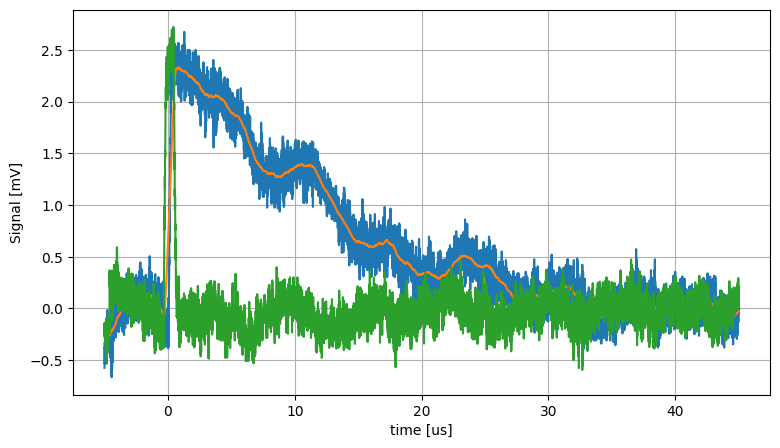

In [126]:

old_bg = 517
print("Old Run Number",old_bg)
bgnum=0
if old_rn > -1:    
    bgnum = Run_oldtonew(old_bg)
    background_waveform = Get_Waveform_from_session(bgnum)
else:
    background_waveform = blankBG_DF
print("Background Run Number",bgnum)

stepcount=200
diffsize=5

#def Anode_BackGround_cleanup(background_waveform,stepcounts=[100],debug=0,plot=False,savefig=True):
if 1:
    """
    Anode_BackGround_cleanup(background_waveform,stepcounts=[100],debug=0,plot=False,savefig=True) -> dict
    This function takes a background waveform and returns a dictionary of the waveforms from the session file."""
    global blankBG_DF
    if debug>=1:
        print("::Anode Background Analysis::")
        print("Background Run Number",bgnum)
    
    AnalysisResults={}

    last_index= np.min([len(background_waveform["time"]),len(background_waveform["anode"])])
    
    background_waveform["time"] = background_waveform["time"][:last_index]
    background_waveform["anode"] = background_waveform["anode"][:last_index]

    
    background_waveform["time"] = background_waveform["time"]/1e3 #convert to us

    background_waveform["anode"] = background_waveform["anode"]*1e3 #convert to mv

    time_resolution = background_waveform["time"][1] - background_waveform["time"][0]
    print("Time Resolution",time_resolution)
    #Find the average anode for the first 5 us and subtract to normalize. 
    anode_normalize = background_waveform["anode"][:int(5/time_resolution)].mean()
    background_waveform["norm"] = {}
    background_waveform["norm"]["anode"] = background_waveform["anode"] - anode_normalize
    background_waveform["norm"]["anode-smoothed"] = np.convolve(background_waveform["norm"]["anode"],  
    np.ones(stepcount)/(stepcount),mode="same")  
    background_waveform["norm"]["anode-derivative"] = np.gradient(background_waveform["norm"]["anode-smoothed"])


    edge_slice=slice(0,int(55/time_resolution))

    der_norm_for_plt = np.max(background_waveform["norm"]["anode"])/np.max(background_waveform["norm"]["anode-derivative"])

    if plot:
        fig_anode, ax_anode = plt.subplots(figsize=(9,5))
        ax_anode.grid()
        ax_anode.set_xlabel("time [us]")
        ax_anode.set_ylabel("Signal [mV]")
        ax_anode.errorbar(x=background_waveform["time"][edge_slice],y=background_waveform["norm"]["anode"][edge_slice], label="Normalized Signal")
        ax_anode.errorbar(x=background_waveform["time"][edge_slice],y=background_waveform["norm"]["anode-smoothed"][edge_slice], label="Smoothed Signal")
        ax_anode.errorbar(x=background_waveform["time"][edge_slice],y=background_waveform["norm"]["anode-derivative"][edge_slice]*der_norm_for_plt, label="Derivative Signal")






# Trial - working

## Analyze anode signal

Old Run Number 782
New Run Number 978
Background Run Number 226
::Anode Analysis::
Run Number 978
Background Run Number 226
Medium Type , [0,1,2], [vacuum, GXe, LXe] 0
Background Subtraction Enabled
Last Index 12502
Last Index 12502 Length of waveform 12502 12502 12502 12502
Time Resolution 0.00399971
Last Index 12502 Length of waveform 12502 12502 12502 12502
Gaussian Fit Parameters [1.61733506e-06 1.38501940e+01 3.08345192e-01]
p0 [1.9162356906235573e-06, 13.892, 0.1]
Avg Low 1.3297445
Avg High 8.955729
Avg Low Std 0.24142572
Avg High Std 0.27071002
Amp- sub 7.6+/-0.6
Amp- denoised 7.6+/-0.4


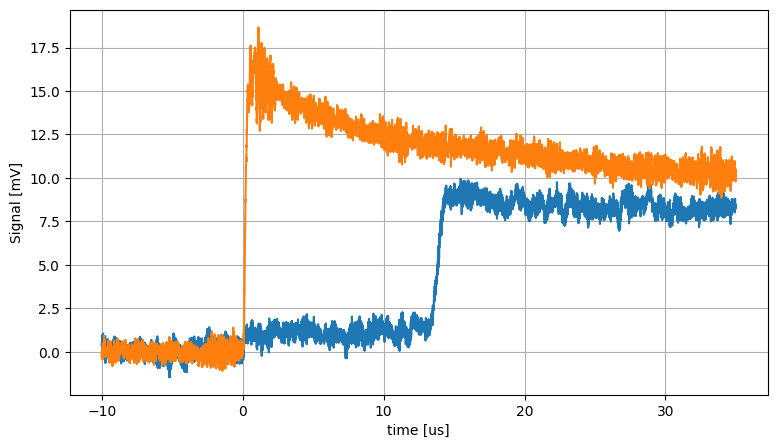

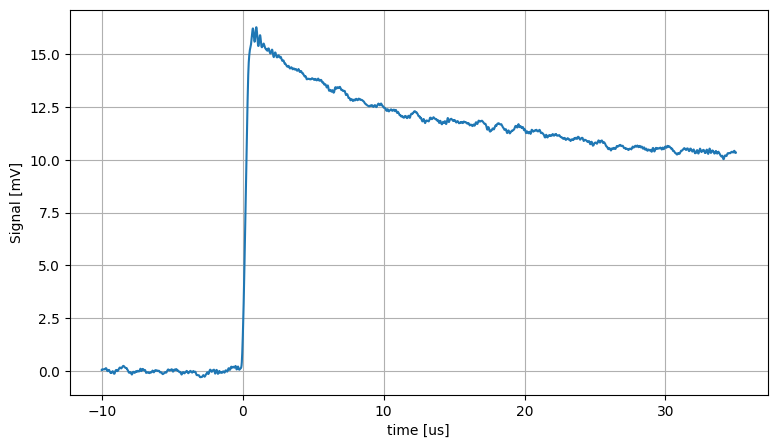

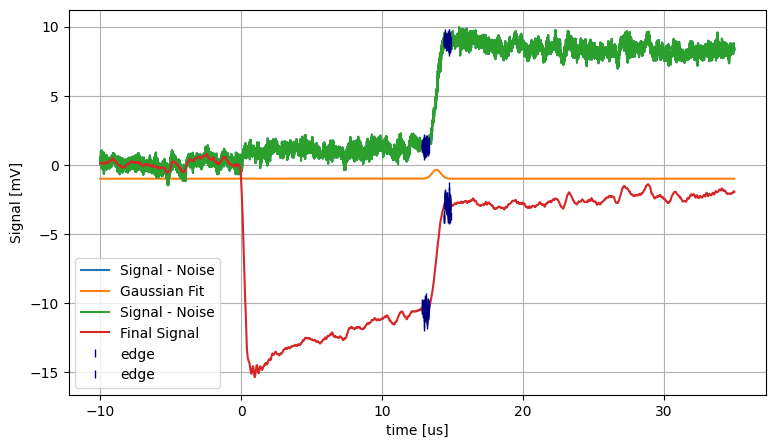

In [136]:
run_number=Run_oldtonew(782)
waveform = Get_Waveform_from_session(run_number)
old_rn = Run_newtoold(run_number)
print("Old Run Number",old_rn)
print("New Run Number",run_number)
bgnum=0
if old_rn > -1:    
    bgnum = Run_oldtonew(GetBGRun(old_rn))
    background_waveform = Get_Waveform_from_session(bgnum)
else:
    background_waveform = blankBG_DF
print("Background Run Number",bgnum)



Anode_dict=Analyze_Anode(waveform,background_waveform,type=0,stepcounts=[100],debug=10,plot=True)



## Analyze cathode

In [137]:
Anode_dict

{'anode': array([24.168531, 24.08943 , 23.98413 , ..., 31.418129, 30.65482 ,
        31.44449 ], dtype=float32),
 'cathode': array([0.06187184, 0.06244027, 0.06226841, ..., 0.02555585, 0.02562153,
        0.02550269], dtype=float32),
 'time': array([-10.004, -10.   ,  -9.996, ...,  39.992,  39.996,  40.   ],
       dtype=float32),
 'trigger': array([-0.03952387,  0.        ,  0.        , ..., -0.03952387,
         0.        , -0.03952387], dtype=float32),
 'uv': array([0., 0., 0., ..., 0., 0., 0.], dtype=float32),
 'norm': {'anode': array([0.5216961 , 0.44259453, 0.33729553, ..., 7.7712936 , 7.007984  ,
         7.797655  ], dtype=float32),
  'anode-bg': array([-0.1358738 , -0.318573  ,  0.11377716, ...,  9.498478  ,
         10.040485  , 10.125706  ], dtype=float32)},
 'denoised': {'anode': array([0.5216961 , 0.44259453, 0.33729553, ..., 7.7712936 , 7.007984  ,
         7.797655  ], dtype=float32),
  'anode-noise': array([0., 0., 0., ..., 0., 0., 0.], dtype=float32),
  'anode-bg': arr

Old Run Number 782
Background Run Number 226
issue with weird data
Gaussian Fit Parameters [5.88686244e-06 9.44179233e-01 5.28575998e-01]
p0 [6.1656877267522074e-06, 1.348, 0.1]
Avg Low 0.24810325
Avg High -46.12337
Avg Low Std 0.5916955
Avg High Std 0.53777313
Amp- denoised 46.4+/-0.8


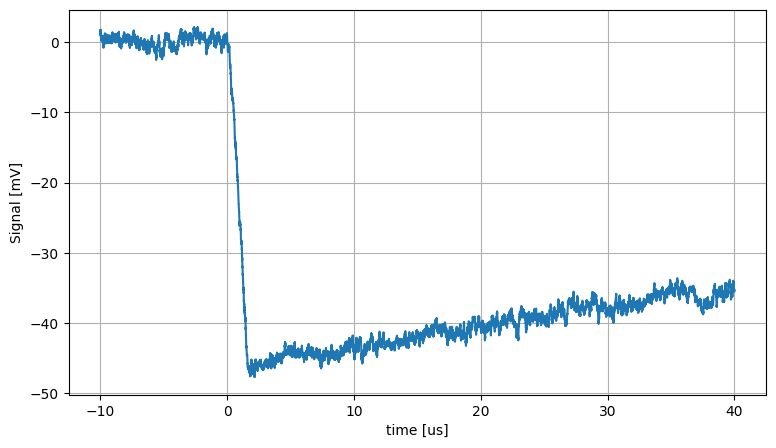

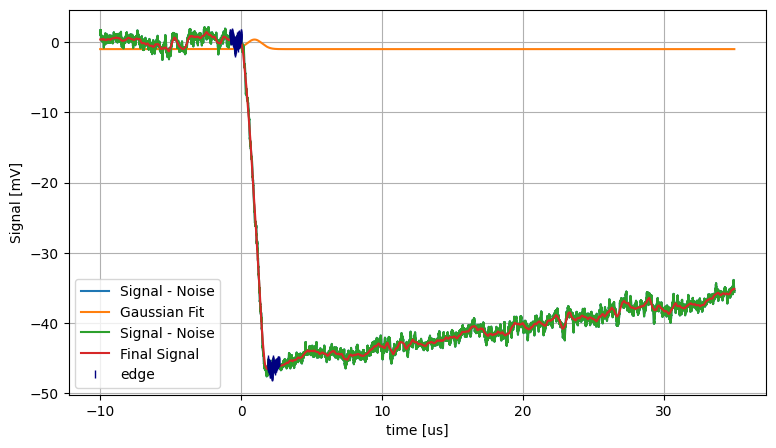

In [128]:
old_run_number=782

run_number = Run_oldtonew(old_run_number)


RunInfo = RunDatabase.query(f'run == {run_number}').iloc[0]

waveform_temp = Get_Waveform_from_session(run_number)
old_rn = Run_newtoold(run_number)
print("Old Run Number",old_rn)
bgnum=0
if old_rn > -1:    
    bgnum = Run_oldtonew(GetBGRun(old_rn))
    background_waveform = Get_Waveform_from_session(bgnum)
else:
    background_waveform = blankBG_DF
print("Background Run Number",bgnum)

renew_flag = True

Cathode_dict=Analyze_Cathode(waveform_temp,background_waveform,type=0,debug=10,plot=True)

## Combine the dicts

In [129]:
print("Previous Anode  analyzed results Dict Keys")
print(Anode_dict["analyzed"]["results"].keys())


for key in Anode_dict.keys():

    print("1: ", key)
    if key in ["norm","denoised","analyzed"]:
        for subkey in Cathode_dict[key].keys():
            print("\t 2:",subkey)
            if key =="analyzed":
                if subkey == "results":
       
                    for sub_subkey in Cathode_dict[key][subkey].keys():
                        print("\t\t 3: ",sub_subkey)
                
                        Anode_dict[key][subkey][sub_subkey] = Cathode_dict[key][subkey][sub_subkey]
                else:
                    Anode_dict[key][subkey] = Cathode_dict[key][subkey]
            
        print(f"key ={key} ",Anode_dict[key])




print("combined analyzed results Dict Keys")
print(Anode_dict["analyzed"]["results"].keys())


Previous Anode  analyzed results Dict Keys
dict_keys(['anode-time-delay', 'anode-time-sigma', 'anode-amp', 'anode-amp-err', 'bg-amp', 'bg-amp-err'])
1:  anode
1:  cathode
1:  time
1:  trigger
1:  uv
1:  norm
	 2: cathode
key =norm  {'anode': array([0.5216961 , 0.44259453, 0.33729553, ..., 7.7712936 , 7.007984  ,
       7.797655  ], dtype=float32), 'anode-bg': array([-0.1358738 , -0.318573  ,  0.11377716, ...,  9.498478  ,
       10.040485  , 10.125706  ], dtype=float32)}
1:  denoised
	 2: cathode
	 2: cathode-noise
key =denoised  {'anode': array([0.5216961 , 0.44259453, 0.33729553, ..., 7.7712936 , 7.007984  ,
       7.797655  ], dtype=float32), 'anode-noise': array([0., 0., 0., ..., 0., 0., 0.], dtype=float32), 'anode-bg': array([-0.1358738 , -0.318573  ,  0.11377716, ...,  9.498478  ,
       10.040485  , 10.125706  ], dtype=float32), 'anode-bg-noise': array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)}
1:  subtracted
1:  analyzed
	 2: cathode
	 2: cathode-derivative
	 2: results
		 

In [130]:
## analysis file name - session_date-analysis_verision.h5
## example file name - 001_230202_analysis_01.h5

RunDatabase.query(f"run==46")

,run,old_run_name,session,date,configuration,grid,run_type,cathode_V,cathode_V_err,cathode_grid_V,...,drift_length_mm_err,run_notes,extraction_length_mm,extraction_length_mm_err,collection_length_mm,collection_length_mm_err,cathode_preamp_gain,cathode_preamp_gain_err,anode_preamp_gain,anode_preamp_gain_err
45,46,20240522-13100079,3,240522,None,NaN,None,NaN,NaN,NaN,...,0.08,None,0.0,0.0,0.51,0.006,0.656,0.001,0.708,0.001


In [134]:
RunDatabase.query('213 <= run <=318').run.unique().tolist()[::-1]

[213,
 214,
 215,
 216,
 217,
 218,
 219,
 220,
 221,
 222,
 223,
 224,
 225,
 226,
 227,
 228,
 229,
 230,
 231,
 232,
 233,
 234,
 235,
 236,
 237,
 238,
 239,
 240,
 241,
 242,
 243,
 244,
 245,
 246,
 247,
 248,
 249,
 250,
 251,
 252,
 253,
 254,
 255,
 256,
 257,
 258,
 259,
 260,
 261,
 262,
 263,
 264,
 265,
 266,
 267,
 268,
 269,
 270,
 271,
 272,
 273,
 274,
 275,
 276,
 277,
 278,
 279,
 280,
 281,
 282,
 283,
 284,
 285,
 286,
 287,
 288,
 289,
 290,
 291,
 292,
 293,
 294,
 295,
 296,
 297,
 298,
 299,
 300,
 301,
 302,
 303,
 304,
 305,
 306,
 307,
 308,
 309,
 310,
 311,
 312,
 313,
 314,
 315,
 316,
 317,
 318]

# Trying to build analysis session

In [ ]:


renew_flag = True
do_sub = 0
debug= 1


all_runs = RunDatabase.query('213 <= run <=318').run.unique().tolist()[::-1]


for run_number in all_runs:




#for old_run_number in [944]:#,945,946,947,948,949,950,951,952,953]:
#    run_number = Run_oldtonew(old_run_number)

    RunInfo = RunDatabase.query(f'run == {run_number}').iloc[0]
    print(run_number)
    waveform_temp = Get_Waveform_from_session(run_number)

    
    old_rn = Run_newtoold(run_number)
    print("Old Run Number",old_rn)
    bgnum = GetBGRun(old_rn)
    print("bgrun",bgnum)
    
    if bgnum > -1:    
        bgnum = Run_oldtonew(bgnum)    
        background_waveform = Get_Waveform_from_session(bgnum)
    else:
        background_waveform = blankBG_DF
    print("Background Run Number",bgnum)

    Anode_dict = {}
    Cathode_dict = {}
    try:
        Anode_dict=Analyze_Anode(waveform_temp.copy(),background_waveform.copy(),type=0,dobg_sub=do_sub,
                        debug=1,plot=0)
    except Exception as e:
        print(f"Anode Analysis Failed for run {run_number} with error: {e}")
        Anode_dict = {"time":waveform["time"],
                    "trigger":waveform_temp["trigger"],
                    "uv":waveform_temp["uv"],
                    "anode":waveform_temp["anode"],
                    "cathode":waveform_temp["cathode"],
                    "norm":{}, "denoised":{}, "subtracted":{}, "analyzed":{}}
    try:
        Cathode_dict=Analyze_Cathode(waveform_temp.copy(),background_waveform.copy(),type=0,dobg_sub=do_sub,
                         debug=1,plot=0)    
    except Exception as e:
        print(f"Cathode Analysis Failed for run {run_number} with error: {e}")
        Cathode_dict = {}



    for key in Anode_dict.keys():

        
        #print("1: ", key)
        if key in ["norm","denoised","analyzed"]:
            for subkey in Cathode_dict[key].keys():
         #       print("\t 2:",subkey)
                if key =="analyzed":
                    if subkey == "results":
        
                        for sub_subkey in Cathode_dict[key][subkey].keys():
          #                  print("\t\t 3: ",sub_subkey)
                    
                            Anode_dict[key][subkey][sub_subkey] = Cathode_dict[key][subkey][sub_subkey]
                    else:
                        Anode_dict[key][subkey] = Cathode_dict[key][subkey]
                


    if debug > 1: print("Attempt to combine ", Anode_dict["analyzed"]["results"].keys())

    

    analysis_file_name = f"{env_session_file_location}\\\\analysis_trial\\\{RunInfo['session']:03}_{RunInfo['date']}_analysis_01.h5"

    print("Analysis File Name",analysis_file_name)

    with h5py.File(analysis_file_name, 'a') as analysis_h5:

        print("Creating Analysis File or appending old file")
        if "run" not in analysis_h5.keys():
            analysis_h5.create_group("run")




        if str(run_number) not in analysis_h5["run"].keys():
            analysis_h5.create_group(f"run/{run_number}")
        # add raw and time
        raw_keys = ["time","trigger","uv","anode","cathode"]
        for key in raw_keys:
            if key not in analysis_h5["run"][str(run_number)].keys():
                analysis_h5["run"][str(run_number)].create_dataset(key, data=waveform_temp[key])

        for analysis_key in ["norm","denoised","subtracted","analyzed"]:
            if analysis_key not in analysis_h5["run"][str(run_number)].keys():
                analysis_h5.create_group(f"run/{run_number}/{analysis_key}")
            else:
                if renew_flag:
                    del analysis_h5["run"][str(run_number)][analysis_key]
                    analysis_h5.create_group(f"run/{run_number}/{analysis_key}")

            
            if analysis_key in waveform.keys():
                for key in waveform[analysis_key].keys():

                    if key not in analysis_h5["run"][str(run_number)][analysis_key].keys():

                        if key == "results":
                            analysis_h5["run"][str(run_number)][analysis_key].create_group(key)
                            for result_key in waveform[analysis_key][key].keys():
                                if result_key not in analysis_h5["run"][str(run_number)][analysis_key][key].keys():
                                    if debug > 1: print(analysis_key, key, result_key)
                                    analysis_h5["run"][str(run_number)][analysis_key][key].create_dataset(result_key, data=waveform[analysis_key][key][result_key])
                                else:
                                    if renew_flag:
                                        del analysis_h5["run"][str(run_number)][analysis_key][key][result_key]
                                        analysis_h5["run"][str(run_number)][analysis_key][key].create_dataset(result_key, data=waveform[analysis_key][key][result_key])

                        
                        else:
                            analysis_h5["run"][str(run_number)][analysis_key].create_dataset(key, data=waveform[analysis_key][key])
                    else:
                        if renew_flag:
                            if key == "results":
                                del analysis_h5["run"][str(run_number)][analysis_key][key]
                                analysis_h5["run"][str(run_number)][analysis_key].create_group(key)
                                for result_key in waveform[analysis_key][key].keys():
                                    if result_key not in analysis_h5["run"][str(run_number)][analysis_key][key].keys():
                                        if debug > 1: print(analysis_key, key, result_key)
                                        analysis_h5["run"][str(run_number)][analysis_key][key].create_dataset(result_key, data=waveform[analysis_key][key][result_key])
                                    else:
                                        if renew_flag:
                                            del analysis_h5["run"][str(run_number)][analysis_key][key][result_key]
                                            analysis_h5["run"][str(run_number)][analysis_key][key].create_dataset(result_key, data=waveform[analysis_key][key][result_key])


                            del analysis_h5["run"][str(run_number)][analysis_key][key]
                            analysis_h5["run"][str(run_number)][analysis_key].create_dataset(key, data=waveform[analysis_key][key])

            # Add attributes to the run group
            atri =get_data_from_session(RunInfo["session"])["run"][str(run_number)]["metadata"]

            for key in atri.keys():       
                if key not in analysis_h5["run"][str(run_number)].attrs.keys():
                    if type(atri[key]) == None:
                        analysis_h5["run"][str(run_number)].attrs[key] = " "
                    else:
                        analysis_h5["run"][str(run_number)].attrs[key] = atri[key]
                else:
                    if renew_flag:
                        del analysis_h5["run"][str(run_number)].attrs[key]
                        if type(atri[key]) == None:
                            analysis_h5["run"][str(run_number)].attrs[key] = " "
                        else:
                            analysis_h5["run"][str(run_number)].attrs[key] = atri[key]



        # Save time, trigger, and UV data to the analysis file
        # analysis_h5["run"][str(run_number)].create_dataset("time", data=waveform["time"])
        # analysis_h5["run"][str(run_number)].create_dataset("trigger", data=waveform["trigger"])
        # analysis_h5["run"][str(run_number)].create_dataset("uv", data=waveform["uv"])

        



213
Old Run Number 6
bgrun -1
Background Run Number -1
::Anode Analysis::
Run Number 213
Background Run Number -1
Medium Type , [0,1,2], [vacuum, GXe, LXe] 0
Issue with offset selection, using default offset
issue with weird data
Issue with offset selection, using default offset
Analysis File Name \\172.24.54.234\\NAS-Lab28\\Data\\analysis_trial\\014_240801_analysis_01.h5


c:\Python310\lib\site-packages\scipy\optimize\_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
C:\Users\jasonbane\AppData\Local\Temp\ipykernel_20676\3798211865.py:113: RuntimeWarning: invalid value encountered in scalar divide
  der_norm_for_plt = np.max(waveform["analyzed"]["cathode"])/np.max(waveform["analyzed"]["cathode-derivative"])
c:\Python310\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Python310\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
c:\Python310\lib\site-packages\numpy\core\_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Python310\lib\site-packages\numpy\core\_methods.py:226: RuntimeWarning: invali

Creating Analysis File or appending old file
214
Old Run Number 7
bgrun -1
Background Run Number -1
::Anode Analysis::
Run Number 214
Background Run Number -1
Medium Type , [0,1,2], [vacuum, GXe, LXe] 0
issue with weird data
Analysis File Name \\172.24.54.234\\NAS-Lab28\\Data\\analysis_trial\\014_240801_analysis_01.h5
Creating Analysis File or appending old file


c:\Python310\lib\site-packages\scipy\optimize\_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
C:\Users\jasonbane\AppData\Local\Temp\ipykernel_20676\3798211865.py:113: RuntimeWarning: invalid value encountered in scalar divide
  der_norm_for_plt = np.max(waveform["analyzed"]["cathode"])/np.max(waveform["analyzed"]["cathode-derivative"])
c:\Python310\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Python310\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
c:\Python310\lib\site-packages\numpy\core\_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Python310\lib\site-packages\numpy\core\_methods.py:226: RuntimeWarning: invali

215
Old Run Number 8
bgrun -1
Background Run Number -1
::Anode Analysis::
Run Number 215
Background Run Number -1
Medium Type , [0,1,2], [vacuum, GXe, LXe] 0
issue with weird data
Analysis File Name \\172.24.54.234\\NAS-Lab28\\Data\\analysis_trial\\014_240801_analysis_01.h5
Creating Analysis File or appending old file


c:\Python310\lib\site-packages\scipy\optimize\_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
C:\Users\jasonbane\AppData\Local\Temp\ipykernel_20676\3798211865.py:113: RuntimeWarning: invalid value encountered in scalar divide
  der_norm_for_plt = np.max(waveform["analyzed"]["cathode"])/np.max(waveform["analyzed"]["cathode-derivative"])
c:\Python310\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Python310\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
c:\Python310\lib\site-packages\numpy\core\_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Python310\lib\site-packages\numpy\core\_methods.py:226: RuntimeWarning: invali

216
Old Run Number 9
bgrun -1
Background Run Number -1
::Anode Analysis::
Run Number 216
Background Run Number -1
Medium Type , [0,1,2], [vacuum, GXe, LXe] 0
issue with weird data
Analysis File Name \\172.24.54.234\\NAS-Lab28\\Data\\analysis_trial\\014_240801_analysis_01.h5
Creating Analysis File or appending old file


c:\Python310\lib\site-packages\scipy\optimize\_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
C:\Users\jasonbane\AppData\Local\Temp\ipykernel_20676\3798211865.py:113: RuntimeWarning: invalid value encountered in scalar divide
  der_norm_for_plt = np.max(waveform["analyzed"]["cathode"])/np.max(waveform["analyzed"]["cathode-derivative"])
c:\Python310\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Python310\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
c:\Python310\lib\site-packages\numpy\core\_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Python310\lib\site-packages\numpy\core\_methods.py:226: RuntimeWarning: invali

217
Old Run Number 10
bgrun -1
Background Run Number -1
::Anode Analysis::
Run Number 217
Background Run Number -1
Medium Type , [0,1,2], [vacuum, GXe, LXe] 0
issue with weird data
Analysis File Name \\172.24.54.234\\NAS-Lab28\\Data\\analysis_trial\\014_240801_analysis_01.h5
Creating Analysis File or appending old file


c:\Python310\lib\site-packages\scipy\optimize\_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
C:\Users\jasonbane\AppData\Local\Temp\ipykernel_20676\3798211865.py:113: RuntimeWarning: invalid value encountered in scalar divide
  der_norm_for_plt = np.max(waveform["analyzed"]["cathode"])/np.max(waveform["analyzed"]["cathode-derivative"])
c:\Python310\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Python310\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
c:\Python310\lib\site-packages\numpy\core\_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Python310\lib\site-packages\numpy\core\_methods.py:226: RuntimeWarning: invali

218
Old Run Number 11
bgrun -1
Background Run Number -1
::Anode Analysis::
Run Number 218
Background Run Number -1
Medium Type , [0,1,2], [vacuum, GXe, LXe] 0
issue with weird data
Analysis File Name \\172.24.54.234\\NAS-Lab28\\Data\\analysis_trial\\014_240801_analysis_01.h5
Creating Analysis File or appending old file


c:\Python310\lib\site-packages\scipy\optimize\_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
C:\Users\jasonbane\AppData\Local\Temp\ipykernel_20676\3798211865.py:113: RuntimeWarning: invalid value encountered in scalar divide
  der_norm_for_plt = np.max(waveform["analyzed"]["cathode"])/np.max(waveform["analyzed"]["cathode-derivative"])
c:\Python310\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Python310\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
c:\Python310\lib\site-packages\numpy\core\_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Python310\lib\site-packages\numpy\core\_methods.py:226: RuntimeWarning: invali

219
Old Run Number 12
bgrun -1
Background Run Number -1
::Anode Analysis::
Run Number 219
Background Run Number -1
Medium Type , [0,1,2], [vacuum, GXe, LXe] 0
issue with weird data
Analysis File Name \\172.24.54.234\\NAS-Lab28\\Data\\analysis_trial\\014_240801_analysis_01.h5
Creating Analysis File or appending old file


c:\Python310\lib\site-packages\scipy\optimize\_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
C:\Users\jasonbane\AppData\Local\Temp\ipykernel_20676\3798211865.py:113: RuntimeWarning: invalid value encountered in scalar divide
  der_norm_for_plt = np.max(waveform["analyzed"]["cathode"])/np.max(waveform["analyzed"]["cathode-derivative"])
c:\Python310\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Python310\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
c:\Python310\lib\site-packages\numpy\core\_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Python310\lib\site-packages\numpy\core\_methods.py:226: RuntimeWarning: invali

220
Old Run Number 13
bgrun -1
Background Run Number -1
::Anode Analysis::
Run Number 220
Background Run Number -1
Medium Type , [0,1,2], [vacuum, GXe, LXe] 0
issue with weird data
Analysis File Name \\172.24.54.234\\NAS-Lab28\\Data\\analysis_trial\\014_240801_analysis_01.h5
Creating Analysis File or appending old file


c:\Python310\lib\site-packages\scipy\optimize\_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
C:\Users\jasonbane\AppData\Local\Temp\ipykernel_20676\3798211865.py:113: RuntimeWarning: invalid value encountered in scalar divide
  der_norm_for_plt = np.max(waveform["analyzed"]["cathode"])/np.max(waveform["analyzed"]["cathode-derivative"])
c:\Python310\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Python310\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
c:\Python310\lib\site-packages\numpy\core\_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Python310\lib\site-packages\numpy\core\_methods.py:226: RuntimeWarning: invali

221
Old Run Number 14
bgrun -1
Background Run Number -1
::Anode Analysis::
Run Number 221
Background Run Number -1
Medium Type , [0,1,2], [vacuum, GXe, LXe] 0
issue with weird data
Analysis File Name \\172.24.54.234\\NAS-Lab28\\Data\\analysis_trial\\014_240801_analysis_01.h5
Creating Analysis File or appending old file


c:\Python310\lib\site-packages\scipy\optimize\_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
C:\Users\jasonbane\AppData\Local\Temp\ipykernel_20676\3798211865.py:113: RuntimeWarning: invalid value encountered in scalar divide
  der_norm_for_plt = np.max(waveform["analyzed"]["cathode"])/np.max(waveform["analyzed"]["cathode-derivative"])
c:\Python310\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Python310\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
c:\Python310\lib\site-packages\numpy\core\_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Python310\lib\site-packages\numpy\core\_methods.py:226: RuntimeWarning: invali

222
Old Run Number 15
bgrun -1
Background Run Number -1
::Anode Analysis::
Run Number 222
Background Run Number -1
Medium Type , [0,1,2], [vacuum, GXe, LXe] 0
issue with weird data
Analysis File Name \\172.24.54.234\\NAS-Lab28\\Data\\analysis_trial\\014_240801_analysis_01.h5
Creating Analysis File or appending old file


c:\Python310\lib\site-packages\scipy\optimize\_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
C:\Users\jasonbane\AppData\Local\Temp\ipykernel_20676\3798211865.py:113: RuntimeWarning: invalid value encountered in scalar divide
  der_norm_for_plt = np.max(waveform["analyzed"]["cathode"])/np.max(waveform["analyzed"]["cathode-derivative"])
c:\Python310\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Python310\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
c:\Python310\lib\site-packages\numpy\core\_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Python310\lib\site-packages\numpy\core\_methods.py:226: RuntimeWarning: invali

223
Old Run Number 16
bgrun -1
Background Run Number -1
::Anode Analysis::
Run Number 223
Background Run Number -1
Medium Type , [0,1,2], [vacuum, GXe, LXe] 0
issue with weird data
Analysis File Name \\172.24.54.234\\NAS-Lab28\\Data\\analysis_trial\\014_240801_analysis_01.h5
Creating Analysis File or appending old file


c:\Python310\lib\site-packages\scipy\optimize\_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
C:\Users\jasonbane\AppData\Local\Temp\ipykernel_20676\3798211865.py:113: RuntimeWarning: invalid value encountered in scalar divide
  der_norm_for_plt = np.max(waveform["analyzed"]["cathode"])/np.max(waveform["analyzed"]["cathode-derivative"])
c:\Python310\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Python310\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
c:\Python310\lib\site-packages\numpy\core\_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Python310\lib\site-packages\numpy\core\_methods.py:226: RuntimeWarning: invali

224
Old Run Number 17
bgrun -1
Background Run Number -1
::Anode Analysis::
Run Number 224
Background Run Number -1
Medium Type , [0,1,2], [vacuum, GXe, LXe] 0
issue with weird data
Analysis File Name \\172.24.54.234\\NAS-Lab28\\Data\\analysis_trial\\014_240801_analysis_01.h5
Creating Analysis File or appending old file


c:\Python310\lib\site-packages\scipy\optimize\_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
C:\Users\jasonbane\AppData\Local\Temp\ipykernel_20676\3798211865.py:113: RuntimeWarning: invalid value encountered in scalar divide
  der_norm_for_plt = np.max(waveform["analyzed"]["cathode"])/np.max(waveform["analyzed"]["cathode-derivative"])
c:\Python310\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Python310\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
c:\Python310\lib\site-packages\numpy\core\_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Python310\lib\site-packages\numpy\core\_methods.py:226: RuntimeWarning: invali

225
Old Run Number 18
bgrun -1
Background Run Number -1
::Anode Analysis::
Run Number 225
Background Run Number -1
Medium Type , [0,1,2], [vacuum, GXe, LXe] 0
issue with weird data
Analysis File Name \\172.24.54.234\\NAS-Lab28\\Data\\analysis_trial\\014_240801_analysis_01.h5
Creating Analysis File or appending old file


c:\Python310\lib\site-packages\scipy\optimize\_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
C:\Users\jasonbane\AppData\Local\Temp\ipykernel_20676\3798211865.py:113: RuntimeWarning: invalid value encountered in scalar divide
  der_norm_for_plt = np.max(waveform["analyzed"]["cathode"])/np.max(waveform["analyzed"]["cathode-derivative"])
c:\Python310\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Python310\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
c:\Python310\lib\site-packages\numpy\core\_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Python310\lib\site-packages\numpy\core\_methods.py:226: RuntimeWarning: invali

226
Old Run Number 19
bgrun -1
Background Run Number -1
::Anode Analysis::
Run Number 226
Background Run Number -1
Medium Type , [0,1,2], [vacuum, GXe, LXe] 0
issue with weird data
Analysis File Name \\172.24.54.234\\NAS-Lab28\\Data\\analysis_trial\\014_240801_analysis_01.h5
Creating Analysis File or appending old file


c:\Python310\lib\site-packages\scipy\optimize\_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
C:\Users\jasonbane\AppData\Local\Temp\ipykernel_20676\3798211865.py:113: RuntimeWarning: invalid value encountered in scalar divide
  der_norm_for_plt = np.max(waveform["analyzed"]["cathode"])/np.max(waveform["analyzed"]["cathode-derivative"])
c:\Python310\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Python310\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
c:\Python310\lib\site-packages\numpy\core\_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Python310\lib\site-packages\numpy\core\_methods.py:226: RuntimeWarning: invali

227
Old Run Number 20
bgrun -1
Background Run Number -1
::Anode Analysis::
Run Number 227
Background Run Number -1
Medium Type , [0,1,2], [vacuum, GXe, LXe] 0
issue with weird data
Analysis File Name \\172.24.54.234\\NAS-Lab28\\Data\\analysis_trial\\014_240801_analysis_01.h5
Creating Analysis File or appending old file


c:\Python310\lib\site-packages\scipy\optimize\_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
C:\Users\jasonbane\AppData\Local\Temp\ipykernel_20676\3798211865.py:113: RuntimeWarning: invalid value encountered in scalar divide
  der_norm_for_plt = np.max(waveform["analyzed"]["cathode"])/np.max(waveform["analyzed"]["cathode-derivative"])
c:\Python310\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Python310\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
c:\Python310\lib\site-packages\numpy\core\_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Python310\lib\site-packages\numpy\core\_methods.py:226: RuntimeWarning: invali

228
Old Run Number 21
bgrun -1
Background Run Number -1
::Anode Analysis::
Run Number 228
Background Run Number -1
Medium Type , [0,1,2], [vacuum, GXe, LXe] 0
issue with weird data
Analysis File Name \\172.24.54.234\\NAS-Lab28\\Data\\analysis_trial\\014_240801_analysis_01.h5
Creating Analysis File or appending old file


c:\Python310\lib\site-packages\scipy\optimize\_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
C:\Users\jasonbane\AppData\Local\Temp\ipykernel_20676\3798211865.py:113: RuntimeWarning: invalid value encountered in scalar divide
  der_norm_for_plt = np.max(waveform["analyzed"]["cathode"])/np.max(waveform["analyzed"]["cathode-derivative"])
c:\Python310\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Python310\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
c:\Python310\lib\site-packages\numpy\core\_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Python310\lib\site-packages\numpy\core\_methods.py:226: RuntimeWarning: invali

229
Old Run Number 22
bgrun -1
Background Run Number -1
::Anode Analysis::
Run Number 229
Background Run Number -1
Medium Type , [0,1,2], [vacuum, GXe, LXe] 0
issue with weird data
Analysis File Name \\172.24.54.234\\NAS-Lab28\\Data\\analysis_trial\\014_240801_analysis_01.h5
Creating Analysis File or appending old file


c:\Python310\lib\site-packages\scipy\optimize\_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
C:\Users\jasonbane\AppData\Local\Temp\ipykernel_20676\3798211865.py:113: RuntimeWarning: invalid value encountered in scalar divide
  der_norm_for_plt = np.max(waveform["analyzed"]["cathode"])/np.max(waveform["analyzed"]["cathode-derivative"])
c:\Python310\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Python310\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
c:\Python310\lib\site-packages\numpy\core\_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Python310\lib\site-packages\numpy\core\_methods.py:226: RuntimeWarning: invali

230
Old Run Number 23
bgrun -1
Background Run Number -1
::Anode Analysis::
Run Number 230
Background Run Number -1
Medium Type , [0,1,2], [vacuum, GXe, LXe] 0
issue with weird data
Analysis File Name \\172.24.54.234\\NAS-Lab28\\Data\\analysis_trial\\014_240801_analysis_01.h5
Creating Analysis File or appending old file


c:\Python310\lib\site-packages\scipy\optimize\_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
C:\Users\jasonbane\AppData\Local\Temp\ipykernel_20676\3798211865.py:113: RuntimeWarning: invalid value encountered in scalar divide
  der_norm_for_plt = np.max(waveform["analyzed"]["cathode"])/np.max(waveform["analyzed"]["cathode-derivative"])
c:\Python310\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Python310\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
c:\Python310\lib\site-packages\numpy\core\_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Python310\lib\site-packages\numpy\core\_methods.py:226: RuntimeWarning: invali

231
Old Run Number 24
bgrun -1
Background Run Number -1
::Anode Analysis::
Run Number 231
Background Run Number -1
Medium Type , [0,1,2], [vacuum, GXe, LXe] 0
issue with weird data
Analysis File Name \\172.24.54.234\\NAS-Lab28\\Data\\analysis_trial\\014_240801_analysis_01.h5
Creating Analysis File or appending old file


c:\Python310\lib\site-packages\scipy\optimize\_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
C:\Users\jasonbane\AppData\Local\Temp\ipykernel_20676\3798211865.py:113: RuntimeWarning: invalid value encountered in scalar divide
  der_norm_for_plt = np.max(waveform["analyzed"]["cathode"])/np.max(waveform["analyzed"]["cathode-derivative"])
c:\Python310\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Python310\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
c:\Python310\lib\site-packages\numpy\core\_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Python310\lib\site-packages\numpy\core\_methods.py:226: RuntimeWarning: invali

232
Old Run Number 25
bgrun -1
Background Run Number -1
::Anode Analysis::
Run Number 232
Background Run Number -1
Medium Type , [0,1,2], [vacuum, GXe, LXe] 0
issue with weird data
Analysis File Name \\172.24.54.234\\NAS-Lab28\\Data\\analysis_trial\\014_240801_analysis_01.h5


c:\Python310\lib\site-packages\scipy\optimize\_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
C:\Users\jasonbane\AppData\Local\Temp\ipykernel_20676\3798211865.py:113: RuntimeWarning: invalid value encountered in scalar divide
  der_norm_for_plt = np.max(waveform["analyzed"]["cathode"])/np.max(waveform["analyzed"]["cathode-derivative"])
c:\Python310\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Python310\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
c:\Python310\lib\site-packages\numpy\core\_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Python310\lib\site-packages\numpy\core\_methods.py:226: RuntimeWarning: invali

Creating Analysis File or appending old file
233
Old Run Number 26
bgrun -1
Background Run Number -1
::Anode Analysis::
Run Number 233
Background Run Number -1
Medium Type , [0,1,2], [vacuum, GXe, LXe] 0
issue with weird data
Analysis File Name \\172.24.54.234\\NAS-Lab28\\Data\\analysis_trial\\014_240801_analysis_01.h5
Creating Analysis File or appending old file


c:\Python310\lib\site-packages\scipy\optimize\_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
C:\Users\jasonbane\AppData\Local\Temp\ipykernel_20676\3798211865.py:113: RuntimeWarning: invalid value encountered in scalar divide
  der_norm_for_plt = np.max(waveform["analyzed"]["cathode"])/np.max(waveform["analyzed"]["cathode-derivative"])
c:\Python310\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Python310\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
c:\Python310\lib\site-packages\numpy\core\_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Python310\lib\site-packages\numpy\core\_methods.py:226: RuntimeWarning: invali

234
Old Run Number 27
bgrun -1
Background Run Number -1
::Anode Analysis::
Run Number 234
Background Run Number -1
Medium Type , [0,1,2], [vacuum, GXe, LXe] 0
issue with weird data
Analysis File Name \\172.24.54.234\\NAS-Lab28\\Data\\analysis_trial\\014_240801_analysis_01.h5
Creating Analysis File or appending old file


c:\Python310\lib\site-packages\scipy\optimize\_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
C:\Users\jasonbane\AppData\Local\Temp\ipykernel_20676\3798211865.py:113: RuntimeWarning: invalid value encountered in scalar divide
  der_norm_for_plt = np.max(waveform["analyzed"]["cathode"])/np.max(waveform["analyzed"]["cathode-derivative"])
c:\Python310\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Python310\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
c:\Python310\lib\site-packages\numpy\core\_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Python310\lib\site-packages\numpy\core\_methods.py:226: RuntimeWarning: invali

235
Old Run Number 28
bgrun -1
Background Run Number -1
::Anode Analysis::
Run Number 235
Background Run Number -1
Medium Type , [0,1,2], [vacuum, GXe, LXe] 0
issue with weird data
Analysis File Name \\172.24.54.234\\NAS-Lab28\\Data\\analysis_trial\\014_240801_analysis_01.h5
Creating Analysis File or appending old file


c:\Python310\lib\site-packages\scipy\optimize\_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
C:\Users\jasonbane\AppData\Local\Temp\ipykernel_20676\3798211865.py:113: RuntimeWarning: invalid value encountered in scalar divide
  der_norm_for_plt = np.max(waveform["analyzed"]["cathode"])/np.max(waveform["analyzed"]["cathode-derivative"])
c:\Python310\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Python310\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
c:\Python310\lib\site-packages\numpy\core\_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Python310\lib\site-packages\numpy\core\_methods.py:226: RuntimeWarning: invali

236
Old Run Number 29
bgrun -1
Background Run Number -1
::Anode Analysis::
Run Number 236
Background Run Number -1
Medium Type , [0,1,2], [vacuum, GXe, LXe] 0
Issue with offset selection, using default offset
issue with weird data
Issue with offset selection, using default offset
Analysis File Name \\172.24.54.234\\NAS-Lab28\\Data\\analysis_trial\\014_240801_analysis_01.h5
Creating Analysis File or appending old file


c:\Python310\lib\site-packages\scipy\optimize\_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
C:\Users\jasonbane\AppData\Local\Temp\ipykernel_20676\3798211865.py:113: RuntimeWarning: invalid value encountered in scalar divide
  der_norm_for_plt = np.max(waveform["analyzed"]["cathode"])/np.max(waveform["analyzed"]["cathode-derivative"])
c:\Python310\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Python310\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
c:\Python310\lib\site-packages\numpy\core\_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Python310\lib\site-packages\numpy\core\_methods.py:226: RuntimeWarning: invali

237
Old Run Number 30
bgrun -1
Background Run Number -1
::Anode Analysis::
Run Number 237
Background Run Number -1
Medium Type , [0,1,2], [vacuum, GXe, LXe] 0
Issue with offset selection, using default offset
issue with weird data
Issue with offset selection, using default offset
Analysis File Name \\172.24.54.234\\NAS-Lab28\\Data\\analysis_trial\\014_240801_analysis_01.h5
Creating Analysis File or appending old file


c:\Python310\lib\site-packages\scipy\optimize\_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
C:\Users\jasonbane\AppData\Local\Temp\ipykernel_20676\3798211865.py:113: RuntimeWarning: invalid value encountered in scalar divide
  der_norm_for_plt = np.max(waveform["analyzed"]["cathode"])/np.max(waveform["analyzed"]["cathode-derivative"])
c:\Python310\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Python310\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
c:\Python310\lib\site-packages\numpy\core\_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Python310\lib\site-packages\numpy\core\_methods.py:226: RuntimeWarning: invali

238
Old Run Number 31
bgrun -1
Background Run Number -1
::Anode Analysis::
Run Number 238
Background Run Number -1
Medium Type , [0,1,2], [vacuum, GXe, LXe] 0
issue with weird data
Analysis File Name \\172.24.54.234\\NAS-Lab28\\Data\\analysis_trial\\014_240801_analysis_01.h5
Creating Analysis File or appending old file


c:\Python310\lib\site-packages\scipy\optimize\_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
C:\Users\jasonbane\AppData\Local\Temp\ipykernel_20676\3798211865.py:113: RuntimeWarning: invalid value encountered in scalar divide
  der_norm_for_plt = np.max(waveform["analyzed"]["cathode"])/np.max(waveform["analyzed"]["cathode-derivative"])
c:\Python310\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Python310\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
c:\Python310\lib\site-packages\numpy\core\_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Python310\lib\site-packages\numpy\core\_methods.py:226: RuntimeWarning: invali

239
Old Run Number 32
bgrun -1
Background Run Number -1
::Anode Analysis::
Run Number 239
Background Run Number -1
Medium Type , [0,1,2], [vacuum, GXe, LXe] 0
issue with weird data
Analysis File Name \\172.24.54.234\\NAS-Lab28\\Data\\analysis_trial\\014_240801_analysis_01.h5
Creating Analysis File or appending old file


c:\Python310\lib\site-packages\scipy\optimize\_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
C:\Users\jasonbane\AppData\Local\Temp\ipykernel_20676\3798211865.py:113: RuntimeWarning: invalid value encountered in scalar divide
  der_norm_for_plt = np.max(waveform["analyzed"]["cathode"])/np.max(waveform["analyzed"]["cathode-derivative"])
c:\Python310\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Python310\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
c:\Python310\lib\site-packages\numpy\core\_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Python310\lib\site-packages\numpy\core\_methods.py:226: RuntimeWarning: invali

240
Old Run Number 33
bgrun -1
Background Run Number -1
::Anode Analysis::
Run Number 240
Background Run Number -1
Medium Type , [0,1,2], [vacuum, GXe, LXe] 0
issue with weird data
Analysis File Name \\172.24.54.234\\NAS-Lab28\\Data\\analysis_trial\\014_240801_analysis_01.h5
Creating Analysis File or appending old file


c:\Python310\lib\site-packages\scipy\optimize\_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
C:\Users\jasonbane\AppData\Local\Temp\ipykernel_20676\3798211865.py:113: RuntimeWarning: invalid value encountered in scalar divide
  der_norm_for_plt = np.max(waveform["analyzed"]["cathode"])/np.max(waveform["analyzed"]["cathode-derivative"])
c:\Python310\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Python310\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
c:\Python310\lib\site-packages\numpy\core\_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Python310\lib\site-packages\numpy\core\_methods.py:226: RuntimeWarning: invali

241
Old Run Number 34
bgrun -1
Background Run Number -1
::Anode Analysis::
Run Number 241
Background Run Number -1
Medium Type , [0,1,2], [vacuum, GXe, LXe] 0
issue with weird data
Analysis File Name \\172.24.54.234\\NAS-Lab28\\Data\\analysis_trial\\014_240801_analysis_01.h5
Creating Analysis File or appending old file


c:\Python310\lib\site-packages\scipy\optimize\_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
C:\Users\jasonbane\AppData\Local\Temp\ipykernel_20676\3798211865.py:113: RuntimeWarning: invalid value encountered in scalar divide
  der_norm_for_plt = np.max(waveform["analyzed"]["cathode"])/np.max(waveform["analyzed"]["cathode-derivative"])
c:\Python310\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Python310\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
c:\Python310\lib\site-packages\numpy\core\_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Python310\lib\site-packages\numpy\core\_methods.py:226: RuntimeWarning: invali

242
Old Run Number 35
bgrun -1
Background Run Number -1
::Anode Analysis::
Run Number 242
Background Run Number -1
Medium Type , [0,1,2], [vacuum, GXe, LXe] 0
issue with weird data
Analysis File Name \\172.24.54.234\\NAS-Lab28\\Data\\analysis_trial\\014_240801_analysis_01.h5
Creating Analysis File or appending old file


c:\Python310\lib\site-packages\scipy\optimize\_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
C:\Users\jasonbane\AppData\Local\Temp\ipykernel_20676\3798211865.py:113: RuntimeWarning: invalid value encountered in scalar divide
  der_norm_for_plt = np.max(waveform["analyzed"]["cathode"])/np.max(waveform["analyzed"]["cathode-derivative"])
c:\Python310\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Python310\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
c:\Python310\lib\site-packages\numpy\core\_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Python310\lib\site-packages\numpy\core\_methods.py:226: RuntimeWarning: invali

243
Old Run Number 36
bgrun -1
Background Run Number -1
::Anode Analysis::
Run Number 243
Background Run Number -1
Medium Type , [0,1,2], [vacuum, GXe, LXe] 0
issue with weird data
Analysis File Name \\172.24.54.234\\NAS-Lab28\\Data\\analysis_trial\\014_240801_analysis_01.h5
Creating Analysis File or appending old file


c:\Python310\lib\site-packages\scipy\optimize\_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
C:\Users\jasonbane\AppData\Local\Temp\ipykernel_20676\3798211865.py:113: RuntimeWarning: invalid value encountered in scalar divide
  der_norm_for_plt = np.max(waveform["analyzed"]["cathode"])/np.max(waveform["analyzed"]["cathode-derivative"])
c:\Python310\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Python310\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
c:\Python310\lib\site-packages\numpy\core\_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Python310\lib\site-packages\numpy\core\_methods.py:226: RuntimeWarning: invali

244
Old Run Number 37
bgrun -1
Background Run Number -1
::Anode Analysis::
Run Number 244
Background Run Number -1
Medium Type , [0,1,2], [vacuum, GXe, LXe] 0
issue with weird data
Analysis File Name \\172.24.54.234\\NAS-Lab28\\Data\\analysis_trial\\014_240801_analysis_01.h5
Creating Analysis File or appending old file


c:\Python310\lib\site-packages\scipy\optimize\_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
C:\Users\jasonbane\AppData\Local\Temp\ipykernel_20676\3798211865.py:113: RuntimeWarning: invalid value encountered in scalar divide
  der_norm_for_plt = np.max(waveform["analyzed"]["cathode"])/np.max(waveform["analyzed"]["cathode-derivative"])
c:\Python310\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Python310\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
c:\Python310\lib\site-packages\numpy\core\_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Python310\lib\site-packages\numpy\core\_methods.py:226: RuntimeWarning: invali

245
Old Run Number 38
bgrun -1
Background Run Number -1
::Anode Analysis::
Run Number 245
Background Run Number -1
Medium Type , [0,1,2], [vacuum, GXe, LXe] 0
issue with weird data
Analysis File Name \\172.24.54.234\\NAS-Lab28\\Data\\analysis_trial\\014_240801_analysis_01.h5
Creating Analysis File or appending old file


c:\Python310\lib\site-packages\scipy\optimize\_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
C:\Users\jasonbane\AppData\Local\Temp\ipykernel_20676\3798211865.py:113: RuntimeWarning: invalid value encountered in scalar divide
  der_norm_for_plt = np.max(waveform["analyzed"]["cathode"])/np.max(waveform["analyzed"]["cathode-derivative"])
c:\Python310\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Python310\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
c:\Python310\lib\site-packages\numpy\core\_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Python310\lib\site-packages\numpy\core\_methods.py:226: RuntimeWarning: invali

246
Old Run Number 39
bgrun -1
Background Run Number -1
::Anode Analysis::
Run Number 246
Background Run Number -1
Medium Type , [0,1,2], [vacuum, GXe, LXe] 0
issue with weird data
Analysis File Name \\172.24.54.234\\NAS-Lab28\\Data\\analysis_trial\\014_240801_analysis_01.h5
Creating Analysis File or appending old file


c:\Python310\lib\site-packages\scipy\optimize\_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
C:\Users\jasonbane\AppData\Local\Temp\ipykernel_20676\3798211865.py:113: RuntimeWarning: invalid value encountered in scalar divide
  der_norm_for_plt = np.max(waveform["analyzed"]["cathode"])/np.max(waveform["analyzed"]["cathode-derivative"])
c:\Python310\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Python310\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
c:\Python310\lib\site-packages\numpy\core\_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Python310\lib\site-packages\numpy\core\_methods.py:226: RuntimeWarning: invali

247
Old Run Number 40
bgrun -1
Background Run Number -1
::Anode Analysis::
Run Number 247
Background Run Number -1
Medium Type , [0,1,2], [vacuum, GXe, LXe] 0
issue with weird data
Analysis File Name \\172.24.54.234\\NAS-Lab28\\Data\\analysis_trial\\014_240801_analysis_01.h5
Creating Analysis File or appending old file


c:\Python310\lib\site-packages\scipy\optimize\_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
C:\Users\jasonbane\AppData\Local\Temp\ipykernel_20676\3798211865.py:113: RuntimeWarning: invalid value encountered in scalar divide
  der_norm_for_plt = np.max(waveform["analyzed"]["cathode"])/np.max(waveform["analyzed"]["cathode-derivative"])
c:\Python310\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Python310\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
c:\Python310\lib\site-packages\numpy\core\_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Python310\lib\site-packages\numpy\core\_methods.py:226: RuntimeWarning: invali

248
Old Run Number 41
bgrun -1
Background Run Number -1
::Anode Analysis::
Run Number 248
Background Run Number -1
Medium Type , [0,1,2], [vacuum, GXe, LXe] 0
issue with weird data
Analysis File Name \\172.24.54.234\\NAS-Lab28\\Data\\analysis_trial\\014_240801_analysis_01.h5
Creating Analysis File or appending old file


c:\Python310\lib\site-packages\scipy\optimize\_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
C:\Users\jasonbane\AppData\Local\Temp\ipykernel_20676\3798211865.py:113: RuntimeWarning: invalid value encountered in scalar divide
  der_norm_for_plt = np.max(waveform["analyzed"]["cathode"])/np.max(waveform["analyzed"]["cathode-derivative"])
c:\Python310\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Python310\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
c:\Python310\lib\site-packages\numpy\core\_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Python310\lib\site-packages\numpy\core\_methods.py:226: RuntimeWarning: invali

249
Old Run Number 42
bgrun -1
Background Run Number -1
::Anode Analysis::
Run Number 249
Background Run Number -1
Medium Type , [0,1,2], [vacuum, GXe, LXe] 0
issue with weird data
Analysis File Name \\172.24.54.234\\NAS-Lab28\\Data\\analysis_trial\\014_240801_analysis_01.h5
Creating Analysis File or appending old file


c:\Python310\lib\site-packages\scipy\optimize\_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
C:\Users\jasonbane\AppData\Local\Temp\ipykernel_20676\3798211865.py:113: RuntimeWarning: invalid value encountered in scalar divide
  der_norm_for_plt = np.max(waveform["analyzed"]["cathode"])/np.max(waveform["analyzed"]["cathode-derivative"])
c:\Python310\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Python310\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
c:\Python310\lib\site-packages\numpy\core\_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Python310\lib\site-packages\numpy\core\_methods.py:226: RuntimeWarning: invali

250
Old Run Number 43
bgrun -1
Background Run Number -1
::Anode Analysis::
Run Number 250
Background Run Number -1
Medium Type , [0,1,2], [vacuum, GXe, LXe] 0
Issue with offset selection, using default offset


IndexError: index 0 is out of bounds for axis 0 with size 0

In [ ]:
x={}
last_index=45
x["x"] = np.arange(0,10,0.1)[:last_index]
print(len(x["x"]))

45


# Analyze Cathode

In [62]:
def Analyze_Cathode(waveform,background_waveform, type=0,dobg_sub=0,stepcounts=[100], diffsizes=[100],debug=0,plot=False,savefig=True):
    """
    Analyze_Cathode(waveform,background_waveform, stepcounts=[100], diffsizes=[100],debug=0,plot=False,savefig=True) -> dict
    This function takes a waveform and background waveform and returns a dictionary of the waveforms from the session file."""
    
    AnalysisResults={}

    last_index= np.min([len(waveform["time"]),len(waveform["cathode"])])
    
    waveform["time"] = waveform["time"][:last_index]
    waveform["cathode"] = waveform["cathode"][:last_index]
    #background_waveform["time"] = background_waveform["time"][:last_index]
    #background_waveform["cathode"] = background_waveform["cathode"][:last_index]
    
    waveform["time"] = waveform["time"]/1e3 #convert to us
    #background_waveform["cathode"] = background_waveform["cathode"]*1e3 #convert to mv
    waveform["cathode"] = waveform["cathode"]*1e3 #convert to mv

    time_resolution = waveform["time"][1] - waveform["time"][0]
    #Find the average anode for the first 5 us and subtract to normalize. 
    cathode_normalize = waveform["cathode"][:int(5/time_resolution)].mean()

    waveform["norm"] = {}
    waveform["denoised"] = {}
    #waveform["subtracted"] = {}
    waveform["analyzed"]={}
    
    #Find the average anode for the first 5 us and subtract to normalize.   
    waveform["norm"]["cathode"] = waveform["cathode"] - cathode_normalize
    #waveform["norm"]["cathode-bg"] = background_waveform["cathode"] - background_waveform["cathode"][:int(5/time_resolution)].mean()
    
    if plot:
        fig_cathode, ax_cathode = plt.subplots(figsize=(9,5))
        ax_cathode.grid()
        ax_cathode.set_xlabel("time [us]")
        ax_cathode.set_ylabel("Signal [mV]")
        ax_cathode.errorbar(x=waveform["time"],y=waveform["norm"]["cathode"], label="Normalized Signal")
        #ax_cathode.errorbar(x=background_waveform["time"],y=background_waveform["norm"]["cathode-bg"], label="Back Ground")

    #Find and remove noise
    denoise_plot = plot==1 or plot==True

    cathode_noise_params, Cathode_noise_cov =GetSinBG(waveform["time"],waveform["norm"]["cathode"],27.5,50,debug=debug,plot=denoise_plot)
    
    #BG_noise_params, BG_noise_cov = GetSinBG(waveform["time"],waveform["norm"]["cathode-bg"],25.5,50,150,debug=debug,plot=denoise_plot)
                                          
    noise_waveform = sin(waveform["time"],cathode_noise_params[0],cathode_noise_params[1],cathode_noise_params[2])
    #bg_noise_waveform = sin(waveform["time"],BG_noise_params[0],BG_noise_params[1],BG_noise_params[2])
    

    #subtract the noise from the cathode signal
    waveform["denoised"]["cathode"] = waveform["norm"]["cathode"] - noise_waveform
    waveform["denoised"]["cathode-noise"]= noise_waveform
    #waveform["denoised"]["cathode-bg"] = waveform["norm"]["cathode-bg"] - bg_noise_waveform   
    #waveform["denoised"]["cathode-bg-noise"]= bg_noise_waveform  

    #Dr the background signal (cathode off)
    # Need to to fit the decay rate of the background signal to extrapolate the background signal
    # if plot==1:
    #     fig_cathode_bg, ax_cathode_bg = plt.subplots(figsize=(9,5))
    #     ax_cathode_bg.grid()
    #     ax_cathode_bg.set_xlabel("time [us]")
    #     ax_cathode_bg.errorbar(x=waveform["time"][edge_slice],
    #             y=np.convolve(waveform["denoised"]["cathode-bg"],
    #             np.ones(stepcount)/(stepcount),mode="same")[edge_slice], label="Back Ground")

    #     ax_cathode_bg.set_ylabel("Signal [mV]")
        

    # #subtract the background from the cathode signal
    # waveform["subtracted"]["cathode"] = waveform["denoised"]["cathode"] - waveform["denoised"]["cathode-bg"]
    # #Convolute the signal to smooth it out
    waveform["analyzed"]["cathode"] = np.convolve(waveform["denoised"]["cathode"],np.ones(stepcount)/stepcount,mode="same")

    if plot:
        fig_cathode_ana, ax_cathode_ana = plt.subplots(figsize=(9,5))
        ax_cathode_ana.grid()
        ax_cathode_ana.set_xlabel("time [us]")
        ax_cathode_ana.set_ylabel("Signal [mV]")
        ax_cathode_ana.errorbar(x=waveform["time"][edge_slice],y=waveform["denoised"]["cathode"][edge_slice], label="Signal - Noise")
        #ax_cathode_ana.errorbar(x=waveform["time"][edge_slice],y=waveform["analyzed"]["cathode"][edge_slice], label="Final Signal")
        
                
    # Start analyzing the signal 
    # Find the peak location, for timing by taking derivative and fitting a gaussian
    waveform["analyzed"]["cathode-derivative"] = -np.gradient(waveform["analyzed"]["cathode"],diffsize/time_resolution)

    # Setting up P0 - use an offset to skip over the "reflection" peak   
    try:                             
        offset_sel = [0,
                        int(np.where(abs(waveform["time"]-0.001)<=0.001)[0][0] + 5/time_resolution),
                        int(np.where(abs(waveform["time"]-0.002)<=0.002)[0][0] + 5/time_resolution)]
    except:
        print("Issue with offset selection, using default offset")
        offset_sel = [0, 0, 0]

    offset = offset_sel[type]

    Amp_p0  = np.max(waveform["analyzed"]["cathode-derivative"][offset:])
    peak_p0 = waveform["time"][np.argmax(waveform["analyzed"]["cathode-derivative"][offset:])+offset]
    sigma_p0 = 0.1
    p0 = [Amp_p0,peak_p0,sigma_p0]
    params, covariance = curve_fit(gaussian, waveform["time"], waveform["analyzed"]["cathode-derivative"],p0=p0)
    fit_y = gaussian(waveform["time"],*params)
    if debug>=5:
        print("Gaussian Fit Parameters",params)
        print("p0",p0)

    # percent values of gaussian for determining the edge locations for the amp calculation
    edge_location_value_1=0.005
    edge_location_value_2=0.2
    der_norm_for_plt = np.max(waveform["analyzed"]["cathode"])/np.max(waveform["analyzed"]["cathode-derivative"])

    peak_index = np.where(np.abs(waveform["time"] - np.round(params[1],2)) <=0.005)
    peak_edge_location = np.where(np.logical_and(fit_y*der_norm_for_plt >= np.max(fit_y*der_norm_for_plt)*edge_location_value_1 
                                                    , fit_y*der_norm_for_plt<=np.max(fit_y*der_norm_for_plt)*edge_location_value_2))[0]
    

    

    if plot >=1:
        fit_y = gaussian(waveform["time"],*params)
        #ax_cathode_ana.errorbar(x=waveform["time"][edge_slice],y=waveform["analyzed"]["cathode-derivative"][edge_slice]*der_norm_for_plt, label="Signal Derivative Scaled for plot")
        ax_cathode_ana.errorbar(x=waveform["time"][edge_slice],y=fit_y[edge_slice]*der_norm_for_plt-1, label="Gaussian Fit")
        ax_cathode_ana.errorbar(x=waveform["time"][edge_slice],y=waveform["denoised"]["cathode"][edge_slice], label="Signal - Noise")
        ax_cathode_ana.errorbar(x=waveform["time"][edge_slice],y=waveform["analyzed"]["cathode"][edge_slice], label="Final Signal")        
        
        ax_cathode_ana.errorbar(x=waveform["time"][peak_edge_location],y=waveform["denoised"]["cathode"][peak_edge_location]
                                ,fmt=" ",marker="|", label="edge", color="Navy")
        # ax_cathode_ana.errorbar(x=waveform["time"][peak_edge_location],y=fit_y[peak_edge_location]*der_norm_for_plt-1, 
        #                       fmt=" ", marker="|",label="Peak Location", color="Navy")
        ax_cathode_ana.legend()

    
    edge_index_1 = np.where(peak_edge_location < peak_index[0][0])
    edge_index_2 = np.where(peak_edge_location > peak_index[0][0])
    
    # #Calculate the average of the low and high edges for the subtracted signal
    # avg_low = np.mean(waveform["subtracted"]["cathode"][peak_edge_location[edge_index_1]])
    # avg_low_std=np.std(waveform["subtracted"]["cathode"][peak_edge_location[edge_index_1]])

    # avg_high = np.mean(waveform["subtracted"]["cathode"][peak_edge_location[edge_index_2]])
    # avg_high_std=np.std(waveform["subtracted"]["cathode"][peak_edge_location[edge_index_2]])
    
    # subtracted_low = ufloat(avg_low,avg_low_std)
    # subtracted_high = ufloat(avg_high,avg_high_std)
    # subtracted_amp= subtracted_high - subtracted_low     
    
    #Cakculate the average of the low and high edges for the denoised signal
    avg_low = np.mean(waveform["denoised"]["cathode"][peak_edge_location[edge_index_1]])
    avg_low_std=np.std(waveform["denoised"]["cathode"][peak_edge_location[edge_index_1]])

    avg_high = np.mean(waveform["denoised"]["cathode"][peak_edge_location[edge_index_2]])
    avg_high_std=np.std(waveform["denoised"]["cathode"][peak_edge_location[edge_index_2]])

    denoised_low = ufloat(avg_low,avg_low_std)
    denoised_high = ufloat(avg_high,avg_high_std)
    denoised_amp= denoised_high - denoised_low    

    if debug>=10:
        print("Avg Low",avg_low)
        print("Avg High",avg_high)
        print("Avg Low Std",avg_low_std)
        print("Avg High Std",avg_high_std)

    denoised_low = ufloat(avg_low,avg_low_std)
    denoised_high = ufloat(avg_high,avg_high_std)
    denoised_amp= np.abs(denoised_high - denoised_low)

    #bg_amp = ufloat(np.max(waveform["denoised"]["cathode-bg"]),0.001)


    amp = denoised_amp      
    
    if debug>=2:
        #print("Amp- sub",subtracted_amp)
        print("Amp- denoised",denoised_amp)

    
    waveform["analyzed"]["results"] = {}
    waveform["analyzed"]["results"]["cathode-time-delay"] = params[1]
    waveform["analyzed"]["results"]["cathode-time-sigma"] = params[2]
    waveform["analyzed"]["results"]["cathode-amp"] = amp.n
    waveform["analyzed"]["results"]["cathode-amp-err"] = amp.s
    # waveform["analyzed"]["results"]["bg-amp"] =bg_amp.n
    # waveform["analyzed"]["results"]["bg-amp-err"] = bg_amp.s

    
    return waveform



In [63]:
old_run_number=952

run_number = Run_oldtonew(old_run_number)


RunInfo = RunDatabase.query(f'run == {run_number}').iloc[0]

waveform_temp = Get_Waveform_from_session(run_number)
old_rn = Run_newtoold(run_number)
print("Old Run Number",old_rn)
bgnum=0
if old_rn > -1:    
    bgnum = Run_oldtonew(GetBGRun(old_rn))
    background_waveform = Get_Waveform_from_session(bgnum)
else:
    background_waveform = blankBG_DF
print("Background Run Number",bgnum)

renew_flag = True

Cathode_dict=Analyze_Cathode(waveform_temp,background_waveform,type=0,debug=10,plot=False)

Old Run Number 952
Background Run Number 226
issue with weird data
Gaussian Fit Parameters [1.09284595e-04 1.58596397e-01 2.89560081e-01]
p0 [0.00010090343359297646, 0.44000003, 0.1]
Avg Low -0.13516328
Avg High -23.658272
Avg Low Std 0.20520076
Avg High Std 0.4401134
Amp- denoised 23.5+/-0.5


In [64]:

def ReadAnalysisResults(run_number, old_or_new='old'):
    """
    ReadAnalysisResults(run_number) -> dict
    This function reads the analysis results from the analysis file for a given run number.
    """

    if old_or_new == 'old':
        run_number = Run_oldtonew(run_number)
    

    RunInfo = RunDatabase.query(f'run == {run_number}').iloc[0]
    analysis_file_name = f"{env_session_file_location}\\\\analysis_trial\\\{RunInfo['session']:03}_{RunInfo['date']}_analysis_01.h5"
    
    with h5py.File(analysis_file_name, 'r') as analysis_h5:
        if "run" in analysis_h5.keys() and str(run_number) in analysis_h5["run"].keys():
            results = {}
            for key in analysis_h5["run"][str(run_number)]["analyzed"]["results"].keys():
                results[key] = analysis_h5["run"][str(run_number)]["analyzed"]["results"][key][()]
            return results
        else:
            print(f"No analysis results found for run number {run_number}")
            return None



In [65]:
run_list=[944,947,948,951,952]

analysis_list={}
for run in run_list:
    analysis_list[run] = ReadAnalysisResults(run, old_or_new='old')
    


Analysis_DF= pd.DataFrame(analysis_list).T

print(Analysis_DF)
    


     anode-amp  anode-amp-err  anode-time-delay  anode-time-sigma     bg-amp  \
944  13.419834       0.421114          0.174433          0.175736  16.944862   
947  13.419834       0.421114          0.174433          0.175736  16.944862   
948  13.419834       0.421114          0.174433          0.175736  16.944862   
951  13.419834       0.421114          0.174433          0.175736  16.944862   
952  13.419834       0.421114          0.174433          0.175736  16.944862   

     bg-amp-err  cathode-amp  cathode-amp-err  cathode-time-delay  \
944       0.001    23.510258         0.832618             0.15561   
947       0.001    23.510258         0.832618             0.15561   
948       0.001    23.510258         0.832618             0.15561   
951       0.001    23.510258         0.832618             0.15561   
952       0.001    23.510258         0.832618             0.15561   

     cathode-time-sigma  
944            0.151409  
947            0.151409  
948            0.151409  


In [66]:
session_files = glob.glob(env_session_file_location + "\\*.h5")

for session_file in session_files:
    # Open the HDF5 file
    with h5py.File(session_file, 'r') as f:
        # Check if 'data' exists in the file
        subdir = f['run']
        for runnumber in subdir.keys():
            channels=subdir[runnumber].keys()
            waveform_data={}
            for channel in channels:
                waveform_data[channel] = subdir[runnumber][channel]
                print(subdir[runnumber][channel])

                print(subdir[runnumber][channel])
                print(waveform_data)
            break


    break


<HDF5 dataset "anode": shape (12501,), type "<f4">
<HDF5 dataset "anode": shape (12501,), type "<f4">
{'anode': <HDF5 dataset "anode": shape (12501,), type "<f4">}
<HDF5 dataset "cathode": shape (12501,), type "<f4">
<HDF5 dataset "cathode": shape (12501,), type "<f4">
{'anode': <HDF5 dataset "anode": shape (12501,), type "<f4">, 'cathode': <HDF5 dataset "cathode": shape (12501,), type "<f4">}
<HDF5 dataset "time": shape (12501,), type "<f4">
<HDF5 dataset "time": shape (12501,), type "<f4">
{'anode': <HDF5 dataset "anode": shape (12501,), type "<f4">, 'cathode': <HDF5 dataset "cathode": shape (12501,), type "<f4">, 'time': <HDF5 dataset "time": shape (12501,), type "<f4">}
<HDF5 dataset "trigger": shape (12501,), type "<f4">
<HDF5 dataset "trigger": shape (12501,), type "<f4">
{'anode': <HDF5 dataset "anode": shape (12501,), type "<f4">, 'cathode': <HDF5 dataset "cathode": shape (12501,), type "<f4">, 'time': <HDF5 dataset "time": shape (12501,), type "<f4">, 'trigger': <HDF5 dataset 

Text(0, 0.5, 'Signal [V]')

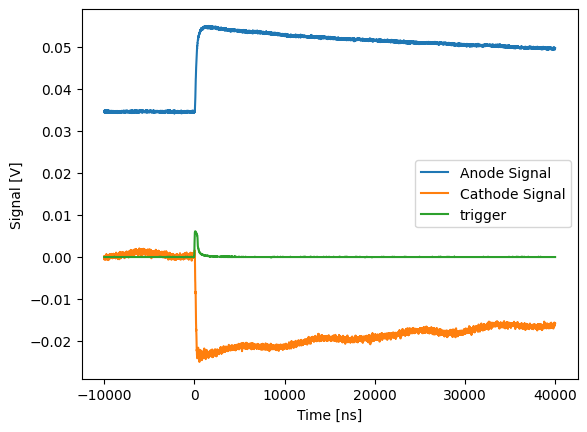

In [67]:
WF = Get_Waveform_from_session(1145)

plt.errorbar(x=WF["time"], y=WF["anode"], label="Anode Signal")
plt.errorbar(x=WF["time"], y=WF["cathode"], label="Cathode Signal")
plt.errorbar(x=WF["time"], y=WF["trigger"]/1000, label="trigger")
plt.legend()

plt.xlabel("Time [ns]")
plt.ylabel("Signal [V]")

## Laser power analysis - calibration for laser settings to injected power


In [68]:
runnumber = 500
debug = 10

#def MeasureLaserpower(runnumber=0, debug=0):
if 1==1:

    if debug >=10:
        print(f"Laser power analysis for Run number: {runnumber}")
    Runinfo = RunDatabase.query(f'run == {runnumber}').iloc[0]
    

    


Laser power analysis for Run number: 500


# Extras


In [14]:
June24th_runs =  get_data_from_session( list(search_runs_in_db({"date":"250624","anode_V":"126"}).keys())[0] )

In [15]:
June24th_runs["run"]

{'1180': {'anode': array([-0.00075818, -0.00030134, -0.00043441, ...,  0.04010904,
          0.04018446,  0.04067686], dtype=float32),
  'cathode': array([ 0.00232937,  0.00242284,  0.00232946, ..., -0.06158713,
         -0.06180088, -0.06160032], dtype=float32),
  'time': array([-5000.5713, -4996.5713, -4992.5713, ..., 44991.426 , 44995.426 ,
         44999.426 ], dtype=float32),
  'trigger': array([-0.03952387,  0.        ,  0.        , ..., -0.03952387,
         -0.03952387, -0.03952387], dtype=float32),
  'uv': array([0., 0., 0., ..., 0., 0., 0.], dtype=float32),
  'metadata': {'anode_V': 126.0,
   'anode_V_err': 0.5,
   'anode_grid_V': 0.0,
   'anode_grid_V_err': 0.5,
   'anode_preamp_gain': 0.657,
   'anode_preamp_gain_err': 0.06,
   'cathode_V': 1352.0,
   'cathode_V_err': 0.5,
   'cathode_grid_V': 1320.0,
   'cathode_grid_V_err': 0.5,
   'cathode_preamp_gain': 0.77,
   'cathode_preamp_gain_err': 0.06,
   'collection_length_mm': 1.57,
   'collection_length_mm_err': 0.01,
   'con

25002 25002
25002 25002
25002 25002
25002 25002
25002 25002


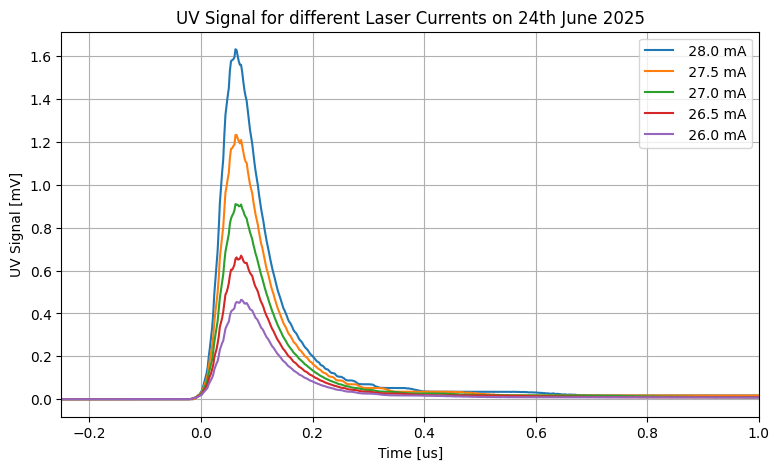

In [113]:
fig1,bx = plt.subplots(figsize=(9,5))


UV_results =[]

for run in  ['1202', '1203', '1204', '1205', '1206'][::-1]:
    
    results = {}

    waveform = June24th_runs["run"][run] 
    if waveform is None:
        print(f"Waveform for run {run} not found.")
        continue
    
    

    laser_A=waveform["metadata"]["laser_A"]
    results["laser_A"] = laser_A

    results["UV peak"] = np.max(waveform["uv"])

    

    print(len(waveform["time"]), len(waveform["uv"]))
    try:
        bx.errorbar(x=waveform["time"]/1e3, y=waveform["uv"], 
                label=f" {laser_A} mA")
    except:
        print(f"Error in plotting run {run} with laser current {laser_A} mA")
        continue
    UV_results.append(results)
    plt.xlabel("Time [us]")
    plt.ylabel("UV Signal [mV]")
    plt.xlim(-0.25,1.)
    plt.grid()
    plt.legend()
    plt.title("UV Signal for different Laser Currents on 24th June 2025")

Analyzing Run 1191
12501
Analyzing Run 1192
12501
Analyzing Run 1193
12501
Analyzing Run 1194
12502
Analyzing Run 1195
12502


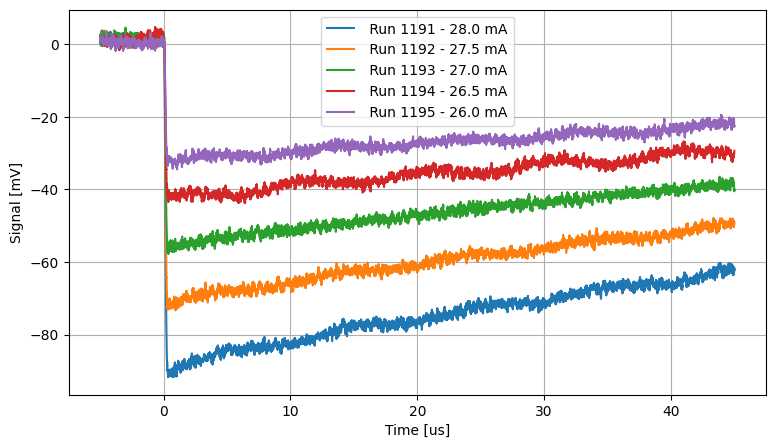

In [83]:
fig,ax = plt.subplots(figsize=(9,5))




June24th_power_cathode_results_2 = []


for run in June24th_runs["run"].keys():
    if run in ['1180','1181','1182','1183','1184','1185','1186','1187','1188','1189','1190', '1196', '1197', '1198', '1199', '1200', '1201', '1202', '1203', '1204', '1205', '1206']:
        continue  # Skip runs that are not in the specified list

    June24th_power_cathode_result_2={}
    print(f"Analyzing Run {run}")
    #plot each anode waveform
    waveform = June24th_runs["run"][run] 
    
    print(len(waveform["anode"])) 

    if len(waveform["anode"]) < 100000:
        plt.errorbar(x=waveform["time"]/1e3, y=waveform["cathode"]*1000, label=f" Run {run} - {waveform['metadata']['laser_A']} mA")

    June24th_power_cathode_result_2["laser_A"] = waveform["metadata"]["laser_A"]
    June24th_power_cathode_result_2["laser_A-err"] = 0.2
    June24th_power_cathode_result_2["cathode-amp"] = np.min(waveform["cathode"])- np.max(waveform["cathode"])
    June24th_power_cathode_result_2["cathode-amp-err"] = 5

    June24th_power_cathode_results_2.append(June24th_power_cathode_result_2)

    


        
    

plt.xlabel("Time [us]")
plt.ylabel("Signal [mV]")
plt.legend(ncol=1)
plt.grid()
plt.legend()

In [74]:
June24th_A_amp =[]

for m,item in enumerate(June24th_power_cathode_results[::-1]):

    item["UV_amp"] = UV_results[m]["UV peak"]
    June24th_A_amp.append(item)

June24th_power_DF = pd.DataFrame(June24th_A_amp)

June24th_power_DF


,laser_A,laser_A-err,cathode-amp,cathode-amp-err,UV_amp
0,26.0,0.2,-0.036227,5,0.463630
1,26.5,0.2,-0.047968,5,0.669577
2,27.0,0.2,-0.059504,5,0.910125
3,27.5,0.2,-0.072972,5,1.232841
4,28.0,0.2,-0.092204,5,1.632230


In [ ]:
June24th_A_amp_2 =[]

for m,item in enumerate(June24th_power_cathode_results_2[::-1]):
    item["UV_amp"] = UV_results[m]["UV peak"]
    June24th_A_amp_2.append(item)

June24th_power_DF_2 = pd.DataFrame(June24th_A_amp_2)

June24th_power_DF_2


0
1
2
3
4


,laser_A,laser_A-err,cathode-amp,cathode-amp-err,UV_amp
0,26.0,0.2,-0.037815,5,0.463630
1,26.5,0.2,-0.048503,5,0.669577
2,27.0,0.2,-0.062282,5,0.910125
3,27.5,0.2,-0.077175,5,1.232841
4,28.0,0.2,-0.095574,5,1.632230


Analyzing Run 1180
12501
Analyzing Run 1181
12502
Analyzing Run 1182
12502
Analyzing Run 1183
12501
Analyzing Run 1184
12501
Analyzing Run 1202
100000
Analyzing Run 1203
100000
Analyzing Run 1204
100000
Analyzing Run 1205
100000
Analyzing Run 1206
100000


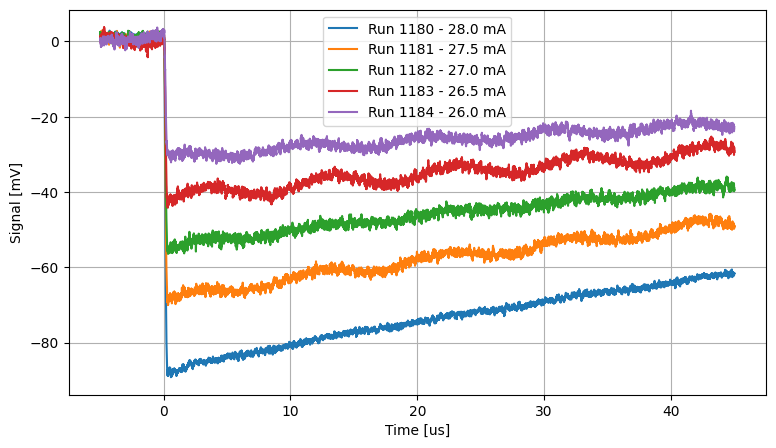

In [81]:
fig,ax = plt.subplots(figsize=(9,5))


June24th_power_cathode_results = []


for run in June24th_runs["run"].keys():
    if run in ['1185','1186','1187','1188','1189','1190','1191', '1192', '1193', '1194', '1195', '1196', '1197', '1198', '1199', '1200', '1201']:
        continue  # Skip runs that are not in the specified list

    June24th_power_cathode_result={}
    print(f"Analyzing Run {run}")
    #plot each anode waveform
    waveform = June24th_runs["run"][run] 
    
    print(len(waveform["anode"])) 
    if waveform["metadata"]["anode_V"] == 126:
        if len(waveform["anode"]) < 100000:
            plt.errorbar(x=waveform["time"]/1e3, y=waveform["cathode"]*1000, label=f"Run { run} - {waveform['metadata']['laser_A']} mA")

        June24th_power_cathode_result["laser_A"] = waveform["metadata"]["laser_A"]
        June24th_power_cathode_result["laser_A-err"] = 0.2
        June24th_power_cathode_result["cathode-amp"] = np.min(waveform["cathode"])- np.max(waveform["cathode"])
        June24th_power_cathode_result["cathode-amp-err"] = 5
        June24th_power_cathode_results.append(June24th_power_cathode_result)

    


        
    

plt.xlabel("Time [us]")
plt.ylabel("Signal [mV]")
plt.legend(ncol=1)
plt.grid()
plt.legend()

Linear Fit Parameters: [0.04702889 0.01560991]
Linear Fit Covariance: [[ 2.28322004e-06 -2.16905904e-06]
 [-2.16905904e-06  2.31176029e-06]]
Linear Fit Parameters: [0.0494278  0.01574903]
Linear Fit Covariance: [[ 8.23600366e-07 -9.05960402e-07]
 [-9.05960402e-07  1.27658057e-06]]


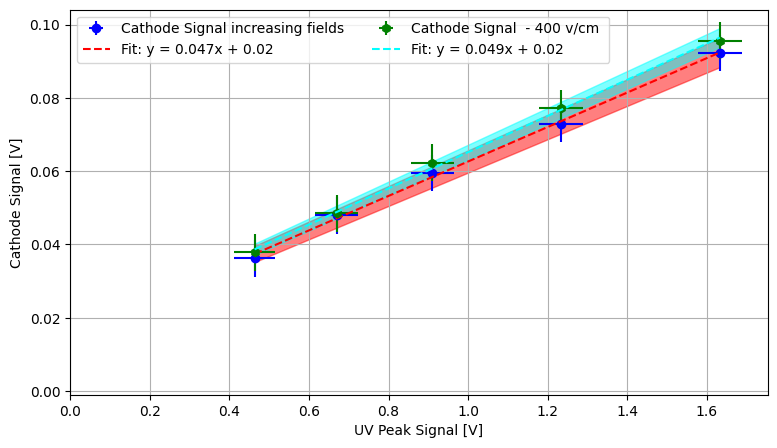

In [ ]:
fig,ax = plt.subplots(figsize=(9,5))

A_plot=[]

A_plot.append(plt.errorbar(x=June24th_power_DF["UV_amp"], y= -June24th_power_DF["cathode-amp"],
            yerr=June24th_power_DF["cathode-amp-err"]/1e3, 
            xerr=June24th_power_DF["laser_A"]*0.002,
            label="Cathode Signal increasing fields", fmt='o', color='blue'))


prange = [[0,-10],[10,10]]
linear_par, linear_cov = curve_fit(lambda x, a, b: a*x + b, June24th_power_DF["UV_amp"], -June24th_power_DF["cathode-amp"], p0=[0.1, 0.1],bounds=prange)

print("Linear Fit Parameters:", linear_par)
print("Linear Fit Covariance:", linear_cov)

fit_x = np.linspace(June24th_power_DF["UV_amp"].min(), June24th_power_DF["UV_amp"].max(), 100)
fit_y = linear_par[0] * fit_x + linear_par[1]
A_plot.append(plt.errorbar(fit_x, fit_y, label=f"Fit: y = {linear_par[0]:.3f}x + {linear_par[1]:.2f}", fmt ="--", color='red'))


fit_y_high = (linear_par[0]+np.sqrt(linear_cov[0][0]) )* fit_x + (linear_par[1] + np.sqrt(linear_cov[1][1]))
fit_y_low = (linear_par[0]-np.sqrt(linear_cov[0][0]) )* fit_x + (linear_par[1] - np.sqrt(linear_cov[1][1]))
A_plot.append(plt.fill_between(fit_x, fit_y_low, fit_y_high, color='red', alpha=0.5, ))







A_plot.append(plt.errorbar(x=June24th_power_DF_2["UV_amp"], y= -June24th_power_DF_2["cathode-amp"],
            yerr=June24th_power_DF_2["cathode-amp-err"]/1e3, 
            xerr=June24th_power_DF_2["laser_A"]*0.002,
            label="Cathode Signal  - 400 v/cm ", fmt='h', color='Green'))


prange = [[0,-10],[10,10]]
linear_par, linear_cov = curve_fit(lambda x, a, b: a*x + b, June24th_power_DF_2["UV_amp"], -June24th_power_DF_2["cathode-amp"], p0=[0.1, 0.1],bounds=prange)

print("Linear Fit Parameters:", linear_par)
print("Linear Fit Covariance:", linear_cov)

fit_x = np.linspace(June24th_power_DF_2["UV_amp"].min(), June24th_power_DF_2["UV_amp"].max(), 100)
fit_y = linear_par[0] * fit_x + linear_par[1]
A_plot.append(plt.errorbar(fit_x, fit_y, label=f"Fit: y = {linear_par[0]:.3f}x + {linear_par[1]:.2f}", fmt ="--", color='cyan'))


fit_y_high = (linear_par[0]+np.sqrt(linear_cov[0][0]) )* fit_x + (linear_par[1] + np.sqrt(linear_cov[1][1]))
fit_y_low = (linear_par[0]-np.sqrt(linear_cov[0][0]) )* fit_x + (linear_par[1] - np.sqrt(linear_cov[1][1]))
A_plot.append(plt.fill_between(fit_x, fit_y_low, fit_y_high, color='cyan',alpha=0.5) )


handles, labels = plt.gca().get_legend_handles_labels()






plt.xlabel("UV Peak Signal [V]")
plt.ylabel("Cathode Signal [V]")
plt.ylim(-0.001,)
plt.xlim(-0.00001,)
plt.legend(ncol=2 )
plt.grid()